In [1]:
# devtools::load_all('~/Numbat')

library(ggplot2)
library(dplyr)
library(Matrix)
library(data.table)
library(stringr)
library(patchwork)
library(glue)
library(ggforce)
library(vcfR)
library(ggpubr)
library(purrr)
library(magrittr)
library(extraDistr)
library(phangorn)
library(IRdisplay)
library(ggtree)
library(tidygraph)
library(parallel)
library(igraph)
library(ggridges)
options(repr.matrix.max.cols=50, repr.matrix.max.rows=50)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



   *****       ***   vcfR   ***       *****
   This is vcfR 1.12.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****



Attaching package: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose



Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names



Attaching package: ‘extraDistr’


The following object is masked from ‘package:purrr’:

    rdunif


Loading required package: ape


Attaching package: ‘ape’


The following object is masked from ‘package:ggpubr’:

    rotate


Registered S3 method overwritten by 'ggtree':
  met

In [2]:
library(Matrix)

In [208]:
load('~/liayson/data/cnps.rda')
load('~/liayson/data/epg.rda')
load('~/liayson/data/eps.rda')
load('~/liayson/data/segments.rda')

segments = segments %>%
    as.data.frame() %>%
    rename(CHROM = chr, seg_start = startpos, seg_end = endpos) %>%
    mutate(CHROM = factor(CHROM)) %>%
    mutate(group = 'NCI-N87', cnv_state = case_when(
        CN_Estimate > 2.25 ~ 'amp',
        CN_Estimate < 1.75 ~ 'del',
        T ~ 'neu'
    ))

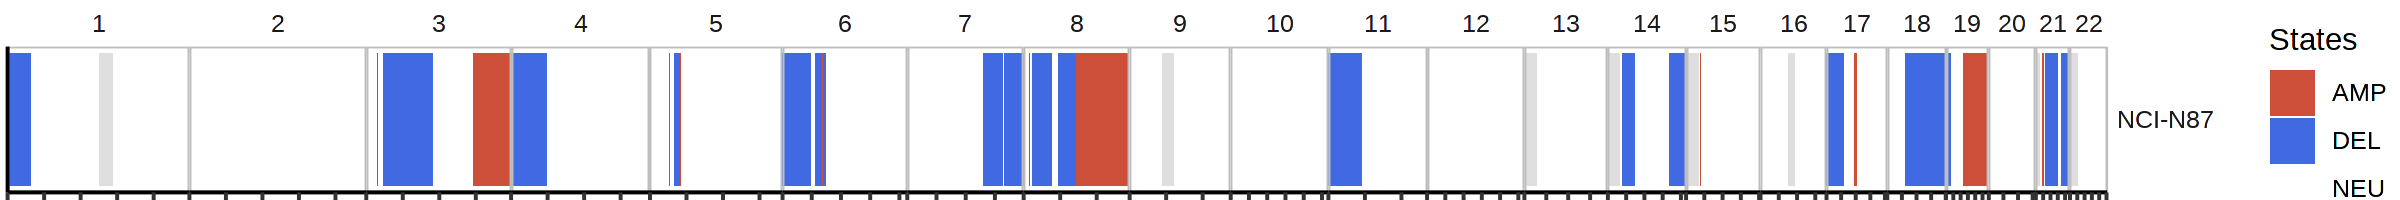

In [209]:
options(repr.plot.width = 12, repr.plot.height = 1, repr.plot.res = 200)

segments %>%
cnv_heatmap()

In [174]:
subtrees = readRDS('/home/tenggao/results/NCI-N87/subtrees_1.rds')

In [50]:
readRDS('~/paper_data/numbat_out/NCI-N87/sc_refs.rds') %>% table

.
Epithelial Macrophage 
      2930        316 

In [177]:
gtf_hg38 = numbat::gtf_hg38

Warning message:
“replacing previous import ‘Matrix::expand’ by ‘ggtree::expand’ when loading ‘numbat’”


In [1308]:
sample = 'NCI-N87'

count_mat = readMM('/home/tenggao/external/STA/NCI-N87/GSM4238683_NCI-N87_matrix.mtx')
cells = fread('/home/tenggao/external/STA/NCI-N87/GSM4238683_NCI-N87_barcodes.tsv.gz', header = FALSE)$V1
genes = fread('/home/tenggao/external/STA/NCI-N87/GSM4238683_NCI-N87_genes.tsv.gz', header = FALSE)$V1
rownames(count_mat) = genes
colnames(count_mat) = cells
count_mat = as(count_mat, "dgCMatrix") 

In [ ]:
gene_dict = readRDS('~/ref/gene_dict.rds')

In [311]:
count_mat = readRDS('~/paper_data/processed/NCI-N87_counts.rds')

In [1591]:
cell_annot = fread('~/external/STA/cell_labels.csv') %>%
    rename(cell = cell_barcode, sample = orig.ident, group = final_celltype)

cell_annot = cell_annot %>% 
    mutate(
        cell = str_replace(cell, '-\\d+', '-1')
    )

In [322]:
normal_samples = cell_annot %>% filter(condition == 'normal') %>% pull(sample) %>% unique

counts = lapply(
    normal_samples,
    function(sample) {
        if (dir.exists((glue('~/external/STA/{sample}')))) {
            counts = readMM(glue('~/external/STA/{sample}/matrix.mtx.gz')) %>% as.matrix
            genes = fread(glue('~/external/STA/{sample}/features.tsv.gz'), header = FALSE)$V1
            cells = fread(glue('~/external/STA/{sample}/barcodes.tsv.gz'), header = FALSE)$V1
            rownames(counts) = genes
            colnames(counts) = cells
            return(counts)
        }
    }
) %>% 
Reduce('cbind', .)

rownames(counts) = gene_dict[rownames(counts)]
counts = counts[!(is.na(rownames(counts)) | rownames(counts) == ''),,drop=F]
counts = rowsum(counts, row.names(counts))

In [339]:
saveRDS(ref_internal, '~/external/STA/ref_internal.rds')

In [323]:
R.utils::sourceDirectory('~/Numbat/R')

ref_internal = aggregate_counts(counts, cell_annot)

cell_dict
          B         CD4         CD8          DC endothelial  epithelial 
        597         782        2164           4         422        2495 
fibroblasts  macrophage        mast          NK   pericytes      plasma 
       1161         221         102         431         139        1156 
       Treg 
        146 


In [454]:
load('~/numbat/data/ref_hca.rda')

In [45]:
# ref_internal = readRDS('~/external/gastric/ref_internal.rds')
ref_internal = readRDS('~/external/gastric/ref_internal.rds')
ref_internal = ref_internal[!duplicated(rownames(ref_internal)),]

In [36]:
library(logger)

In [1144]:
R.utils::sourceDirectory('~/Numbat/R')

bulk = get_bulk(
    count_mat,
    ref_hca,
    df,
    gtf_hg38,
    genetic_map_hg38
)

In [43]:
segs_loh = bulk %>% detect_loh(t = 1e-4)

In [8]:
segs_loh %>% fwrite('~/paper_data/numbat_out/NCI-N87/segs_loh.tsv', sep = '\t')

In [1145]:
bulk = bulk %>% analyze_bulk(t= )

Warning message:
“attributes are not identical across measure variables; they will be dropped”
Warning message:
“Using alpha for a discrete variable is not advised.”


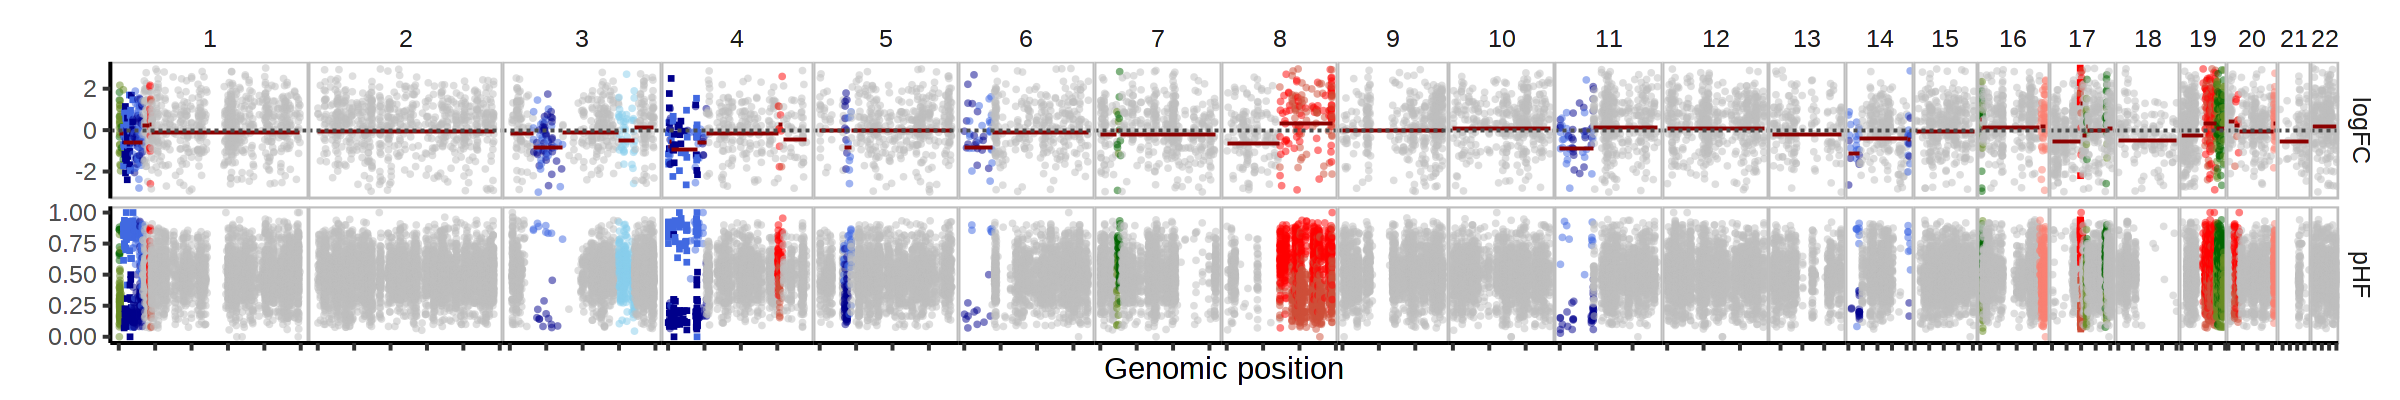

In [522]:
options(repr.plot.width = 12, repr.plot.height = 2, repr.plot.res = 200)

bulk %>%
plot_psbulk(min_depth = 10, use_pos = TRUE, exp_limit = 3, min_LLR = 0, phi_mle = T)

In [1125]:
bulk_tumors = readRDS('~/paper_data/cnv_benchmark/bulk_tumors.rds')

In [1126]:
R.utils::sourceDirectory('~/Numbat/R')

bulk = bulk_tumors[['47491_Primary']] %>% analyze_bulk()

Retesting CNVs..



Warning message:
“attributes are not identical across measure variables; they will be dropped”
Warning message:
“Using alpha for a discrete variable is not advised.”


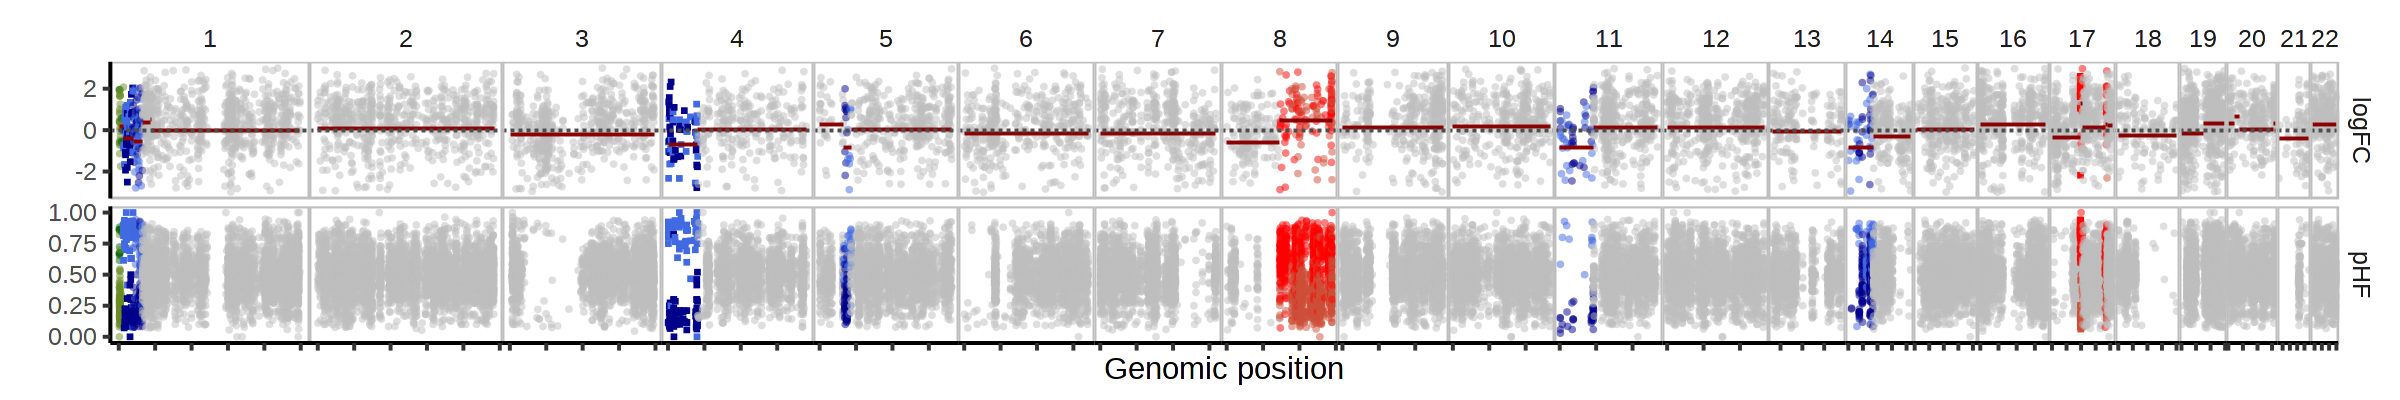

In [1124]:
options(repr.plot.width = 12, repr.plot.height = 2, repr.plot.res = 200)

bulk %>% mutate(LLR = LLR2) %>% plot_psbulk(min_depth = 10, use_pos = TRUE, exp_limit = 3, min_LLR = 10, phi_mle = T)

In [1809]:
R.utils::sourceDirectory('~/Numbat/R')

segs_loh_all = lapply(
    c(bulk_tumors, list('NCI-N87' = bulk)),
    function(bulk) {
        bulk %>% detect_loh(t=1e-5)
    }
)

In [444]:
library(ggraph)

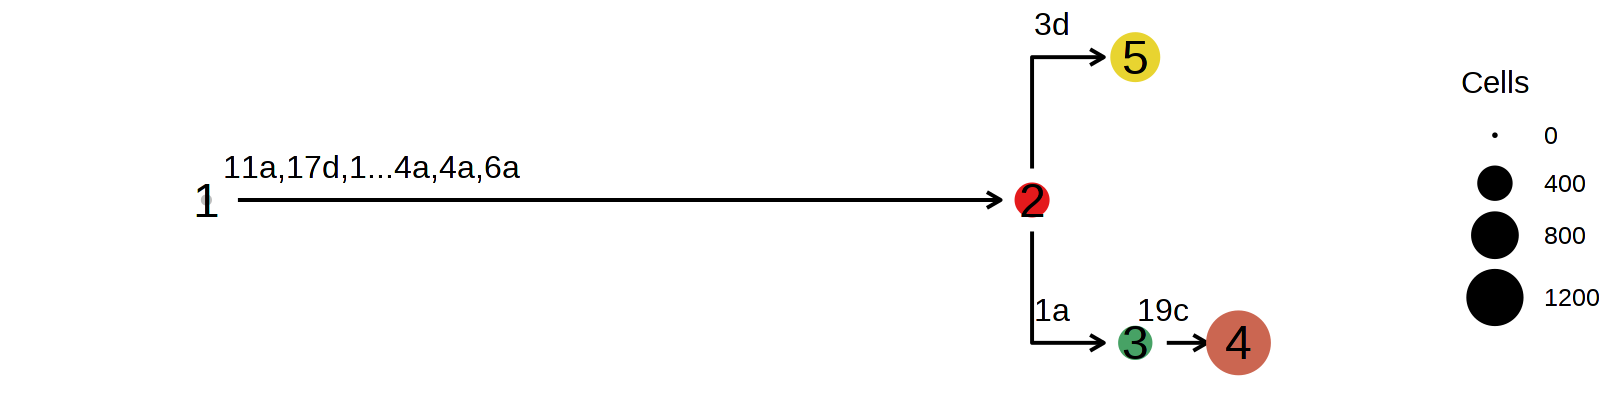

In [448]:
options(repr.plot.width = 8, repr.plot.height = 2, repr.plot.res = 200)

nb$plot_mut_history()

In [1156]:
R.utils::sourceDirectory('~/Numbat/R')

segments = list()
scores = list()

for (i in 1:5) {
    scores = nb$bulk_clones %>% evaluate_segs(segments[[i]], ncores = 20) %>%
        mutate(sample = i)
}

1

2

3

4

5



In [ ]:
lapply(
    segs_subtrees,
    function(segs) {
        bulk_clones %>% 
            evaluate_segs(segs, ncores = ncores) %>%
            mutate(sample = unique(segs$sample))
    }
) %>%
bind_rows()

In [1251]:
bulk_clones = fread(glue('~/paper_data/numbat_out/NCI-N87_new/bulk_clones_2.tsv.gz'), sep = '\t') %>% relevel_chrom
bulk_subtrees = fread(glue('~/paper_data/numbat_out/NCI-N87_new/bulk_subtrees_2.tsv.gz'), sep = '\t') %>% relevel_chrom

In [1638]:
plots = lapply(
    segs_loh_all,
    function(bulk) {
        p = ggplot(
            bulk,
            aes(x = POS, y = snp_rate)
        ) +
        geom_segment(aes(x = seg_start, xend = seg_end, y = snp_rate, yend = snp_rate, color = loh), size = 1) +
        facet_grid(~CHROM, space = 'free_x', scales = 'free_x') +
        theme_classic() +
        theme(
            panel.spacing.x = unit(0, 'mm'),
            panel.spacing.y = unit(1, 'mm'),
            panel.border = element_rect(size = 0.5, color = 'gray', fill = NA),
            strip.background = element_blank(),
            axis.text.x = element_blank(),
            legend.position = 'none'
        ) +
        scale_color_manual(
            values = cnv_colors,
            limits = force,
            labels = cnv_labels,
            na.translate = F
        ) +
        ylim(0,NA)
        return(p)
    }
)

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 200)

wrap_plots(plots, ncol = 1)

In [1129]:
acen = fread('~/ref/chromosome.band.hg38.txt') %>%
    rename(CHROM = `#chrom`) %>%
    filter(gieStain == 'acen') %>%
    mutate(acen_start = chromStart, acen_end = chromEnd) %>%
    mutate(CHROM = str_remove(CHROM, 'chr')) %>%
    mutate(CHROM = factor(CHROM)) %>%
    filter(CHROM %in% 1:22)

In [611]:
D = bulk %>% 
    mutate(cnv_state_post = ifelse(CHROM == 18 & gene_start > 3e7, 'del', cnv_state_post)) %>%
    mutate(cnv_state_post = ifelse(CHROM == 21 & gene_start < 3e7, 'del', cnv_state_post)) %>%
    mutate(cnv_state_post = ifelse(CHROM == 7 & gene_start > 1.1e8, 'del', cnv_state_post)) %>%
    group_by(CHROM, gene, gene_start, gene_end) %>%
    summarise(
        gene_snps = sum(!is.na(AD)),
        cnv_state = unique(cnv_state_post),
        .groups = 'drop'
    ) %>%
    mutate(gene_length = gene_end - gene_start) %>%
    filter(!is.na(gene))

In [619]:
D = D %>% 
    group_by(CHROM) %>%
    mutate(lambda_roll = lambda_roll(gene_snps, gene_length, h = 50)) %>%
    ungroup()

Warning message:
“Removed 1 rows containing missing values (geom_point).”


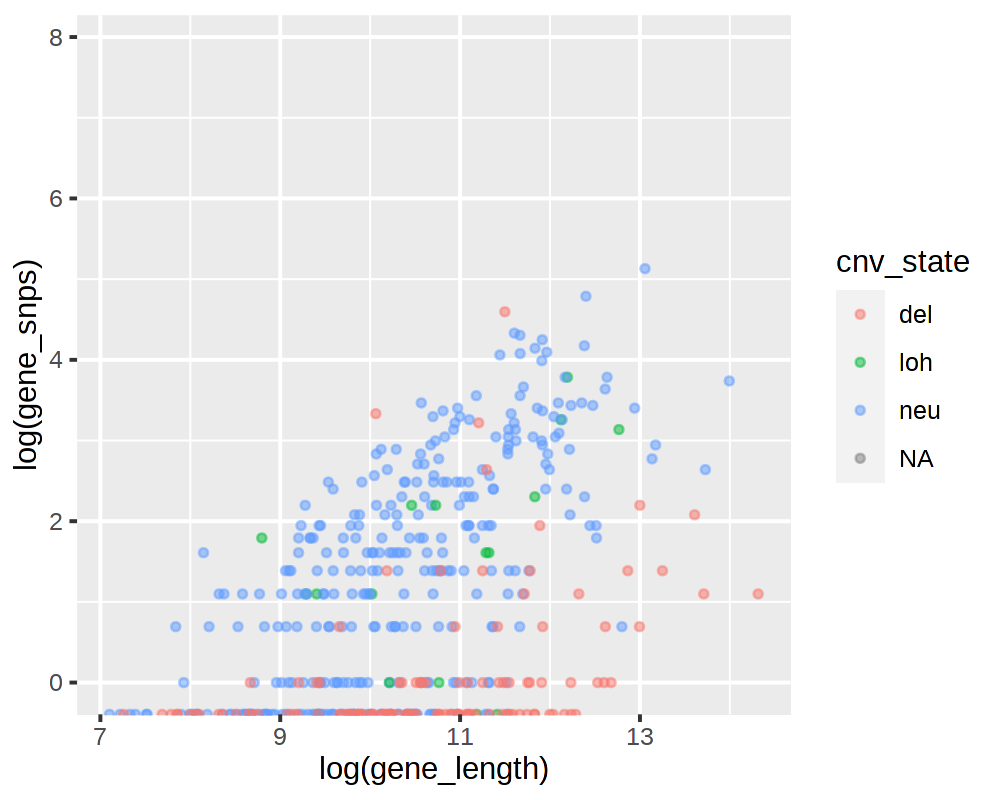

In [559]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 200)

bulk %>% 
mutate(cnv_state_post = ifelse(CHROM == 18 & gene_start > 3e7, 'del', cnv_state_post)) %>%
mutate(cnv_state_post = ifelse(CHROM == 21 & gene_start < 3e7, 'del', cnv_state_post)) %>%
mutate(cnv_state_post = ifelse(CHROM == 7 & gene_start > 1.1e8, 'del', cnv_state_post)) %>%
group_by(CHROM, gene, gene_start, gene_end) %>%
summarise(
    gene_snps = sum(!is.na(AD)),
    cnv_state = unique(cnv_state_post),
    .groups = 'drop'
) %>%
mutate(gene_length = gene_end - gene_start) %>%
filter(CHROM %in% c(7)) %>%
ggplot(
    aes(x = log(gene_length), y = log(gene_snps), color = cnv_state)
) +
geom_point(size = 1, alpha = 0.5)
# ylim(0,200)

In [16]:
nb = Numbat$new('~/paper_data/numbat_out/NCI-N87_new', i = 2)

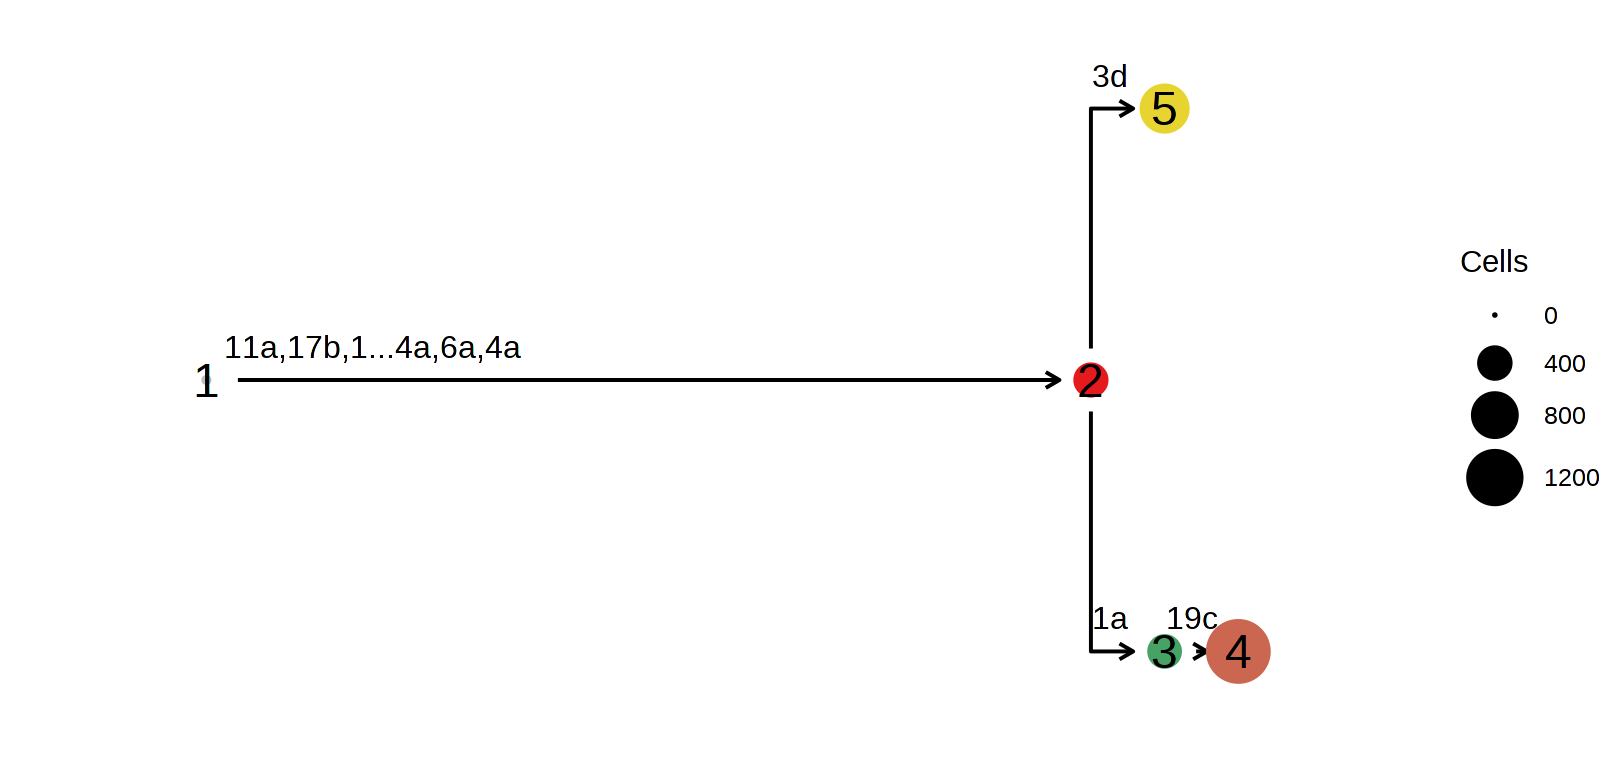

In [1349]:
nb$plot_mut_history()

In [76]:
rename = dplyr::rename

In [840]:
nb$segs_consensus = nb$segs_consensus %>% mutate(
    cnv_state_post = ifelse(cnv_state_post == 'bdel', 'del', cnv_state_post),
    cnv_state_post = ifelse(cnv_states == 'bdel', 'del', cnv_states)
)

In [847]:
nb$joint_post = nb$joint_post %>% mutate(cnv_state = ifelse(cnv_state == 'bdel', 'del', cnv_state)) 

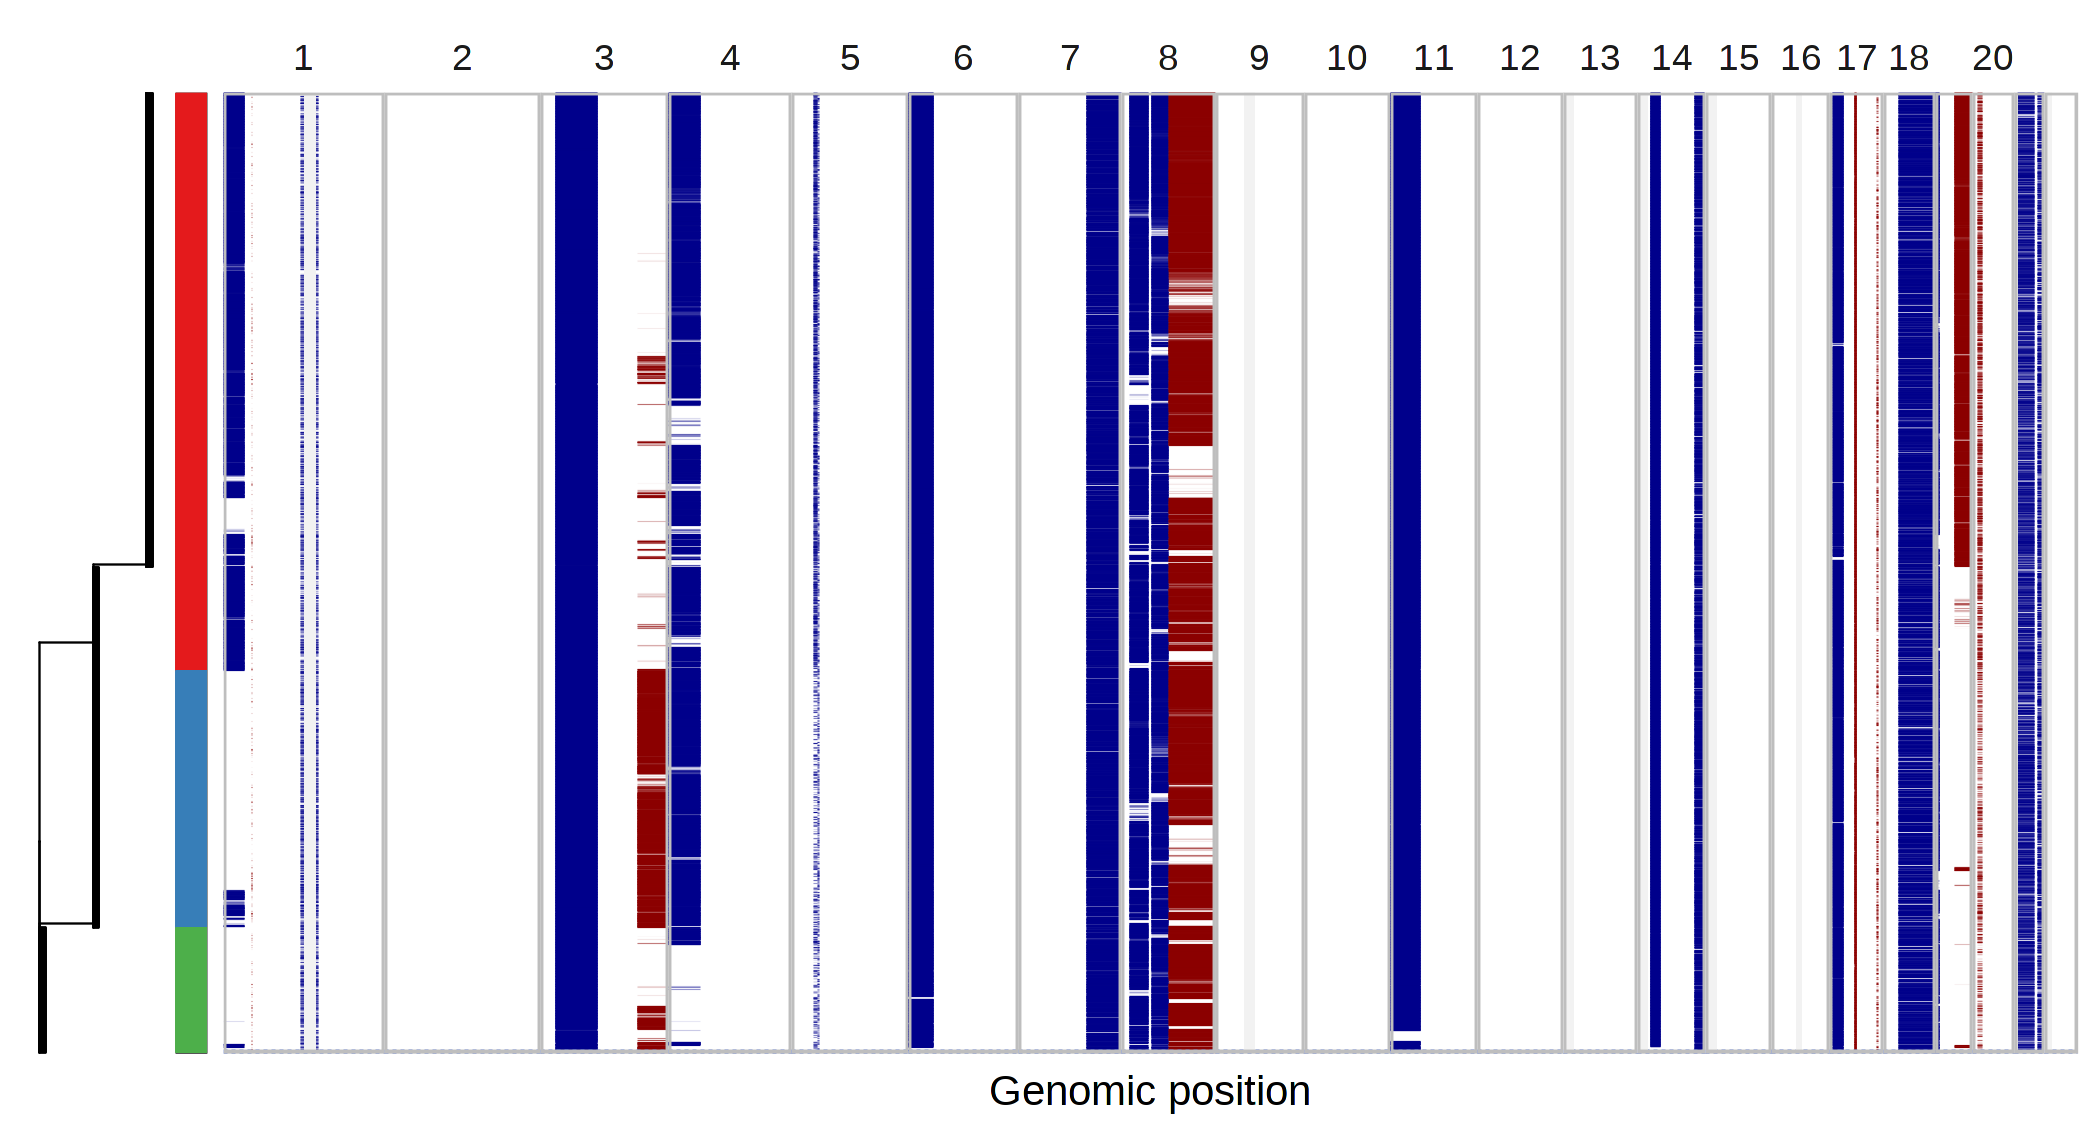

In [848]:
options(repr.plot.width = 7, repr.plot.height = 3.8, repr.plot.res = 300)
R.utils::sourceDirectory('~/Numbat/R')

p = nb$plot_phylo_heatmap(
    clone_bar = TRUE, 
    p_min = 0.5,
    tip_length = 0.1,
    tree_height = 1,
    clone_line = FALSE,
    clone_legend = FALSE,
    exclude_gap = TRUE,
    pal_clone = c('2' = pal[3], '4' = pal[1], '5' = pal[2], '3' = pal[1])
)

p + theme(legend.position = 'none')

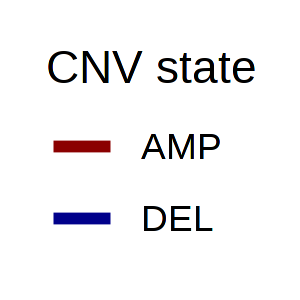

In [850]:
options(repr.plot.width = 1, repr.plot.height = 1, repr.plot.res = 300)

p %>%
ggpubr::get_legend() %>% 
ggpubr::as_ggplot()

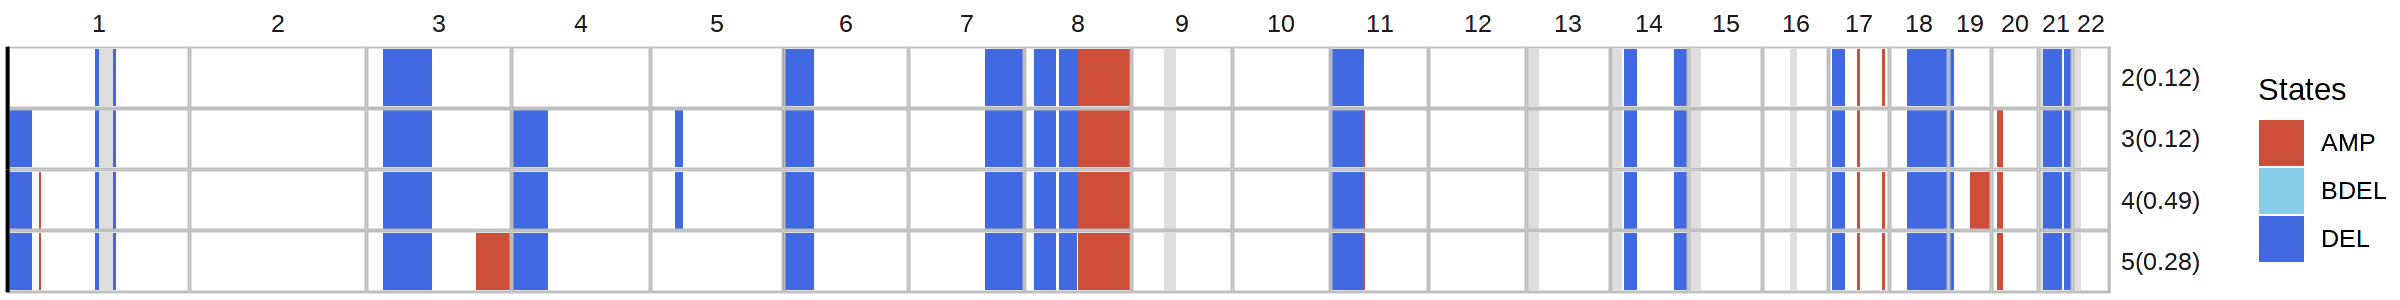

In [1358]:
options(repr.plot.width = 12, repr.plot.height = 1.5, repr.plot.res = 200)
R.utils::sourceDirectory('~/Numbat/R')

n_total = sum(unique(nb$bulk_clones$n_cells))

nb$bulk_clones %>% 
filter(sample != 1) %>%
split(.$sample) %>%
lapply(
    function(bulk) {
        
        frac = unique(bulk$n_cells)/n_total
        
        get_segs_consensus(bulk) %>% 
            bind_rows(segs_loh) %>%
            mutate(loh = ifelse(is.na(loh), FALSE, loh)) %>%
            mutate(
                sample = unique(na.omit(sample)), 
                cnv_state_post = ifelse(loh, 'del', cnv_state_post)
            ) %>%
            mutate(sample = glue('{sample}({round(frac, 2)})'))
    }
) %>%
bind_rows() %>%
mutate(cnv_state = cnv_state_post) %>%
filter(cnv_state != 'neu') %>%
cnv_heatmap(var = 'sample')

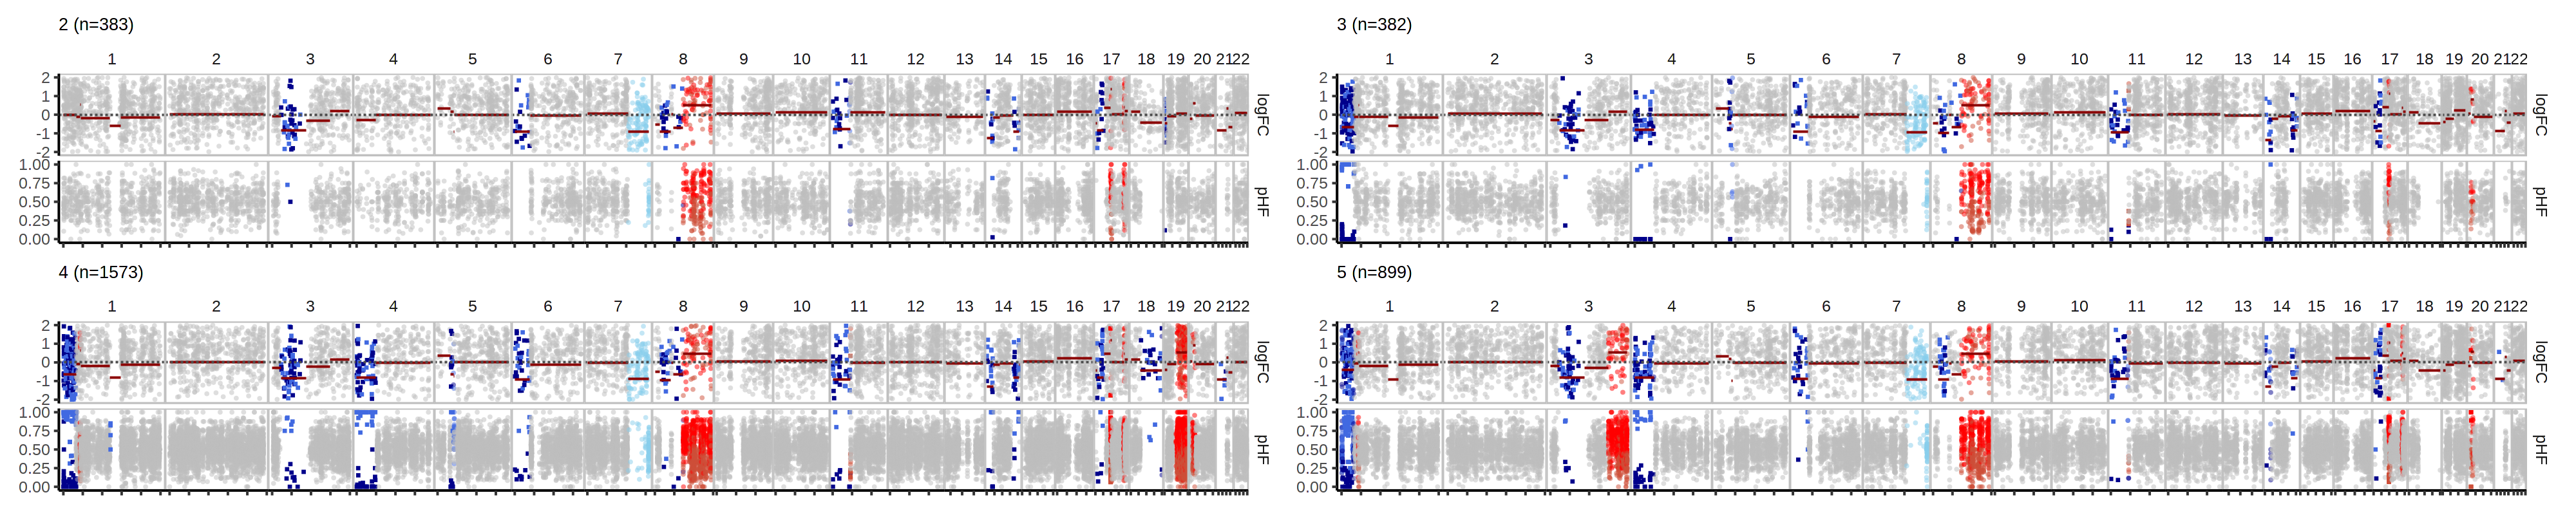

In [109]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 200)

nb$bulk_clones %>%
plot_bulks(ncol = 2, use_pos = TRUE, min_LLR = 5)

In [114]:
R.utils::sourceDirectory('~/Numbat/R')

bulk_clones = nb$bulk_clones %>% 
    run_group_hmms(
        t = 1e-5,
        segs_loh = segs_loh,
        ncores = 5,
        retest = TRUE)

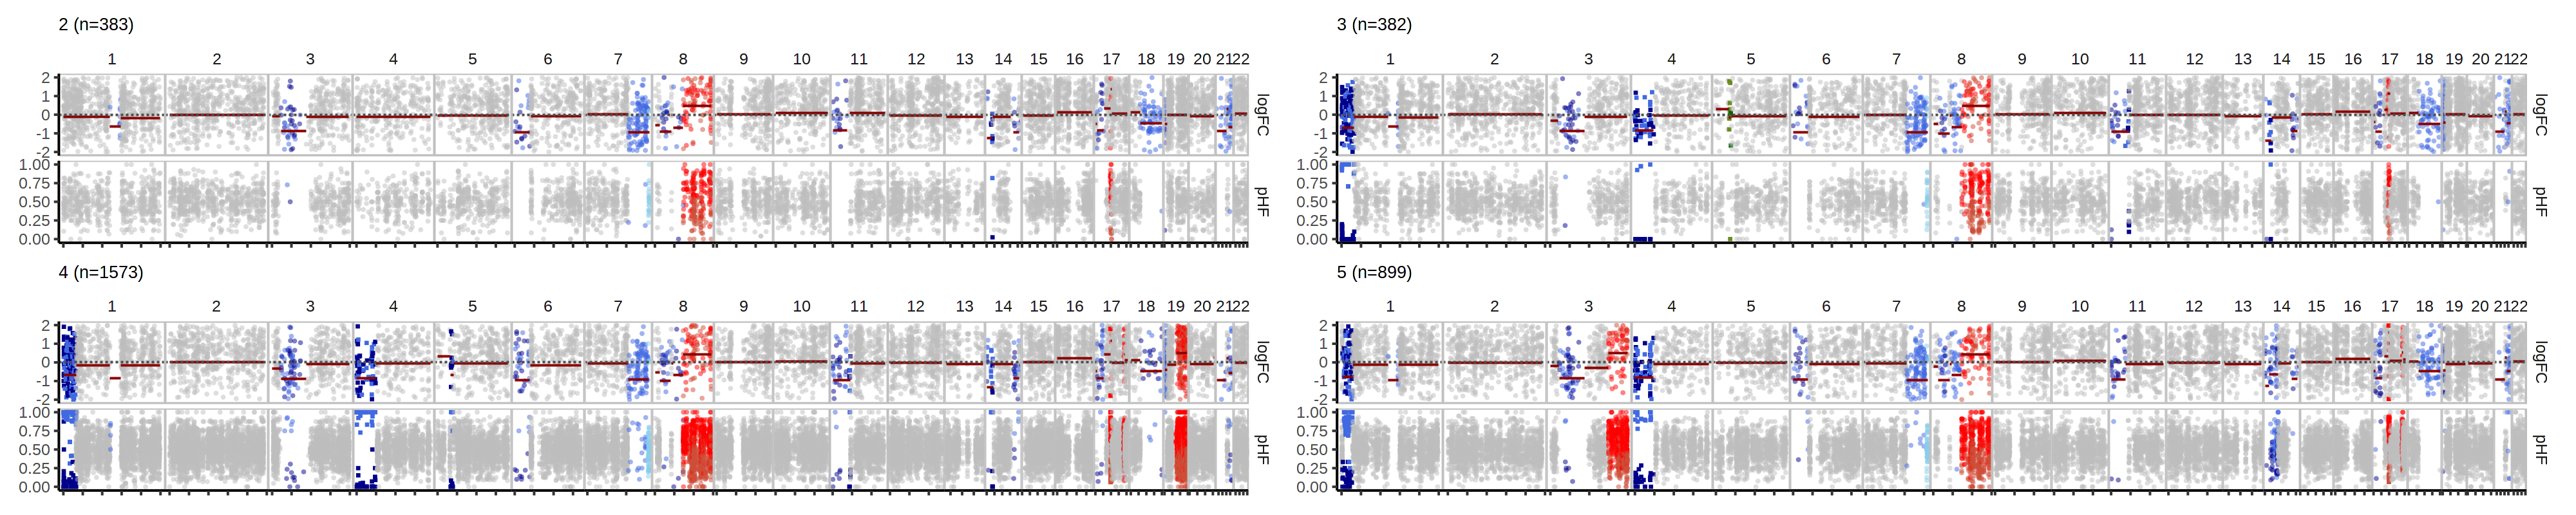

In [115]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 200)

bulk_clones %>%
plot_bulks(ncol = 2, use_pos = TRUE, min_LLR = 5)

In [915]:
plot_cell = function(dat_ratios, dat_segs, cells, ploidy = 1.94) {
    
    gaps_hg38_filtered = gaps_hg38 %>% filter(end - start > 1e6)
    
    chrom_labeller <- function(chr){
        chr = str_remove(chr, 'chr')
        chr[chr %in% c(19, 21, 22)] = ''
        return(chr)
    }


    dat_ratios %>%
    filter(cell %in% cells) %>%
    ggplot(
        aes(x = start, y = ratio * ploidy)
    ) +
    geom_point(size = 0.1, , color = 'gray') +
    scale_y_continuous(breaks = scales::pretty_breaks()) +
    scale_x_continuous(expand = expansion(0)) +
    facet_grid(cell~CHROM, scale = 'free_x', space = 'free_x', labeller = labeller(chrom = chrom_labeller)) +
    theme_classic() +
    theme(
        panel.spacing = unit(0, 'mm'),
        panel.border = element_rect(size = 0.5, color = 'gray', fill = NA),
        strip.background = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks = element_blank(),
        plot.margin = margin(0,0,5,0, unit = 'mm'),
        axis.line = element_blank(),
        legend.box.background = element_blank(),
        legend.background = element_blank()
    ) +
    geom_line(
        data = dat_segs %>% filter(cell %in% cells),
        aes(x = start, y = round(ratio * ploidy)),
        color = 'darkred',
        size = 0.5
    ) +
    geom_rect(
        inherit.aes = F,
        data = gaps_hg38_filtered,
        aes(xmin = start, 
            xmax = end,
            ymin = -Inf,
            ymax = Inf),
        fill = 'gray',
        alpha = 0.5
    ) +
    # ylab('Relative coverage') +
    coord_cartesian(ylim = c(0,5)) +
    # geom_hline(yintercept = 2, linetype = 'dashed', color = 'blue') +
    ylab('TCN') +
    xlab('Genomic position')
}

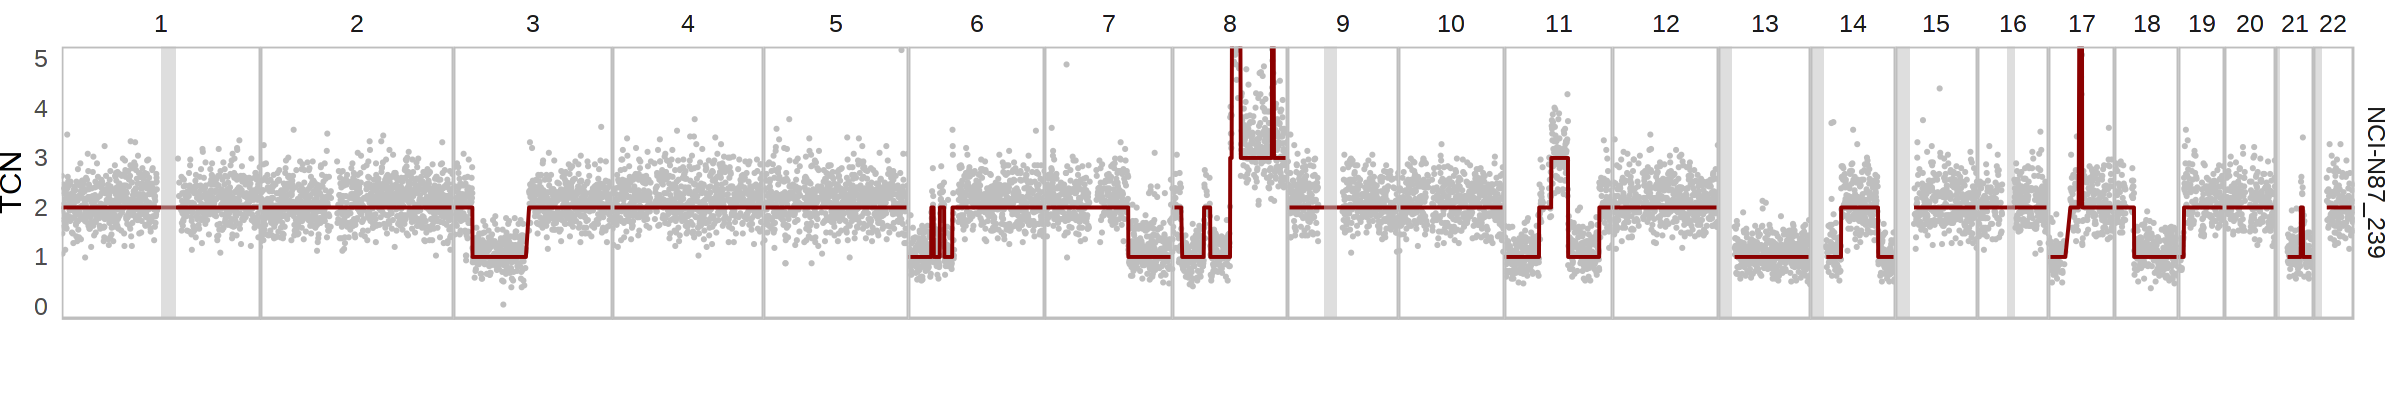

In [916]:
options(repr.plot.width = 12, repr.plot.height = 2, repr.plot.res = 200)

plot_cell(dat_ratios, dat_segs, cells = 'NCI-N87_239', ploidy = 1.94) + xlab('')

In [921]:
sample_to_cell = c('239', '938', '950', '965') %>% paste0('NCI-N87_', .) %>%
    setNames(c('2','3','4','5'))

panels = list()

for (sample in c(2,4,5)) {
    
    p_rna = bulk_clones %>% 
        filter(sample == UQ(sample)) %>%
        get_segs_consensus() %>% 
        bind_rows(segs_loh) %>%
        mutate(loh = ifelse(is.na(loh), FALSE, loh)) %>%
        mutate(
            sample = unique(na.omit(sample)), 
            cnv_state = ifelse(loh, 'del', cnv_state_post)
        ) %>%
        filter(cnv_state != 'neu') %>%
        cnv_heatmap(var = 'sample', legend = FALSE) +
        theme(strip.text.y = element_blank())

    p_dna = plot_cell(dat_ratios, dat_segs, cells = sample_to_cell[as.character(sample)], ploidy = 1.94) + xlab('') +
        theme(plot.margin = margin(0, 0, 0, 0), axis.title.x = element_blank(), strip.text = element_blank())

    panels = c(panels, list(p_rna, p_dna))
    
}

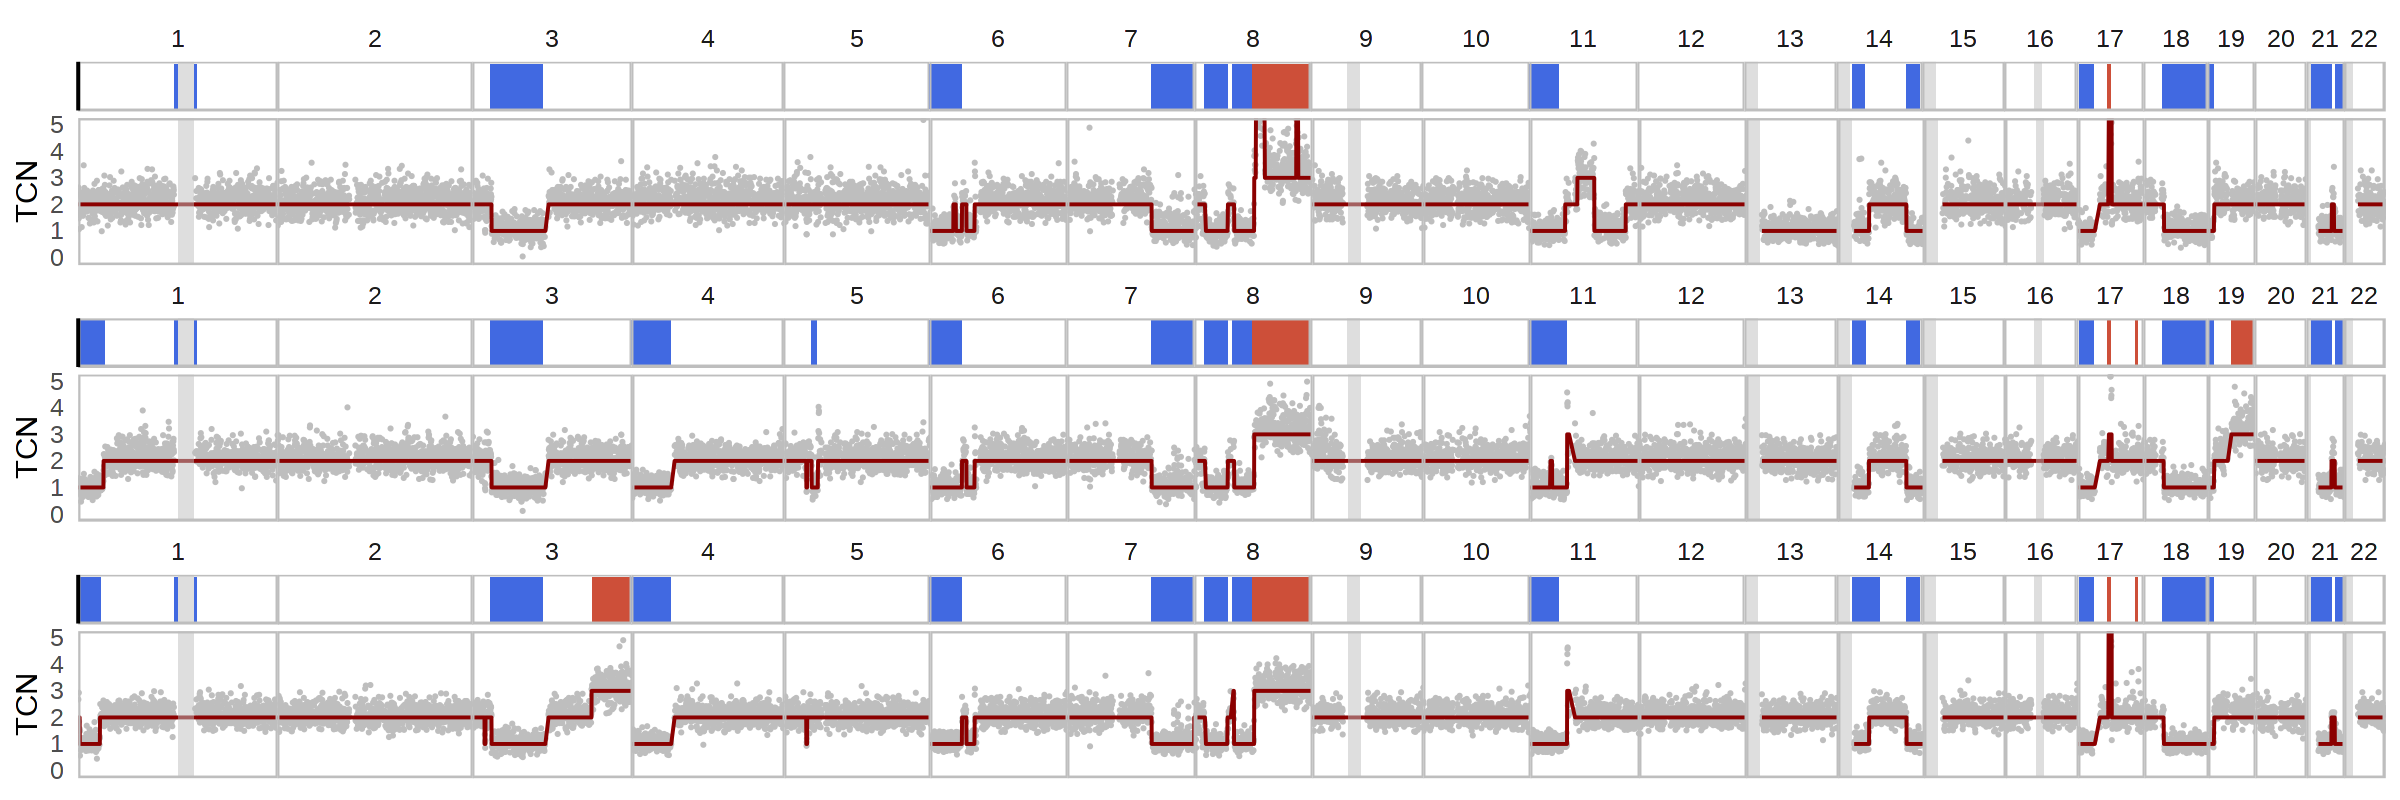

In [922]:
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200)

wrap_plots(panels, ncol = 1) + plot_layout(heights = rep(c(1,3), 3))

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 1.5, repr.plot.res = 200)
R.utils::sourceDirectory('~/Numbat/R')

n_total = sum(unique(nb$bulk_clones$n_cells))

bulk_clones %>% 
filter(sample != 1) %>%
split(.$sample) %>%
lapply(
    function(bulk) {
        
        frac = unique(bulk$n_cells)/n_total
        
        get_segs_consensus(bulk) %>% 
            bind_rows(segs_loh) %>%
            mutate(loh = ifelse(is.na(loh), FALSE, loh)) %>%
            mutate(
                sample = unique(na.omit(sample)), 
                cnv_state_post = ifelse(loh, 'del', cnv_state_post)
            ) %>%
            mutate(sample = glue('{sample}({round(frac, 2)})'))
    }
) %>%
bind_rows() %>%
mutate(cnv_state = cnv_state_post) %>%
filter(cnv_state != 'neu') %>%
cnv_heatmap(var = 'sample')

In [86]:
get_clone_profile = function(joint_post, clone_post) {
    joint_post %>%
    inner_join(
        clone_post %>% select(cell, clone = clone_opt),
        by = 'cell'
    ) %>%
    group_by(clone, CHROM, seg, seg_start, seg_end, cnv_state) %>%
    summarise(
        p_cnv = mean(p_cnv),
        size = n(),
        .groups = 'drop'
    ) %>%
    mutate(CHROM = factor(CHROM, 1:22))
}

In [103]:
count = dplyr::count

In [106]:
get_clone_profile(nb$joint_post, nb$clone_post) %>% filter(cnv_state == 'bdel')

clone CHROM seg seg_start seg_end   cnv_state p_cnv     size
1 1     7     7b  105532081 158949888 bdel      0.1471405    9
2 2     7     7b  105532081 158949888 bdel      0.2521615  393
3 3     7     7b  105532081 158949888 bdel      0.2602885  381
4 4     7     7b  105532081 158949888 bdel      0.2533452 1574
5 5     7     7b  105532081 158949888 bdel      0.2188269  889

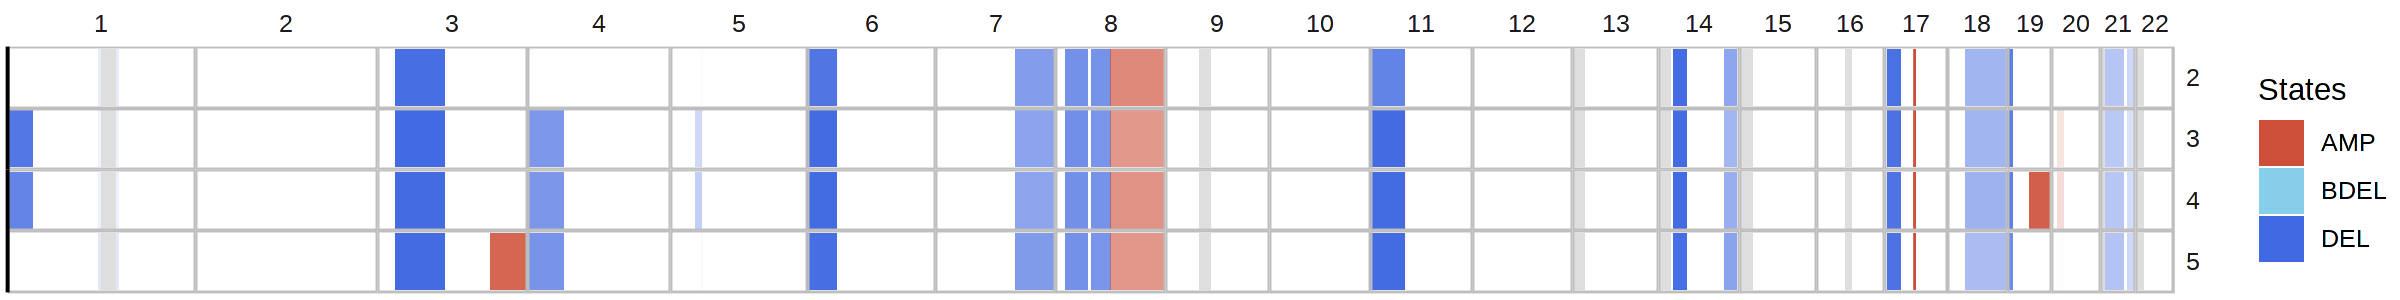

In [100]:
options(repr.plot.width = 12, repr.plot.height = 1.5, repr.plot.res = 200)
R.utils::sourceDirectory('~/Numbat/R')

get_clone_profile(nb$joint_post, nb$clone_post) %>% 
filter(clone != 1) %>% 
cnv_heatmap(var = 'clone')

In [801]:
D = nb$bulk_clones %>% 
    distinct(n_cells, sample) %>%
    mutate(clone = case_when(
        sample %in% c(3,4) ~ 'Major',
        sample == 2 ~ 'Ancestral', 
        sample == 5 ~ 'Minor'
    )) %>%
    group_by(clone) %>%
    summarise(
        n_cells = sum(n_cells)
    ) %>%
    ungroup() %>%
    mutate(frac = n_cells/sum(n_cells)) %>%
    select(-n_cells) %>%
    mutate(assay = 'scRNA')

D = D %>% rbind(data.frame(
        clone = c('Major', 'Minor', 'Ancestral'),
        frac = clone_sizes_dna/sum(clone_sizes_dna),
        assay = 'scDNA'
    ))

In [785]:
clusters = cutree(hc, k = 3)

In [793]:
clone_sizes_dna = unlist(as.list(table(clusters)))

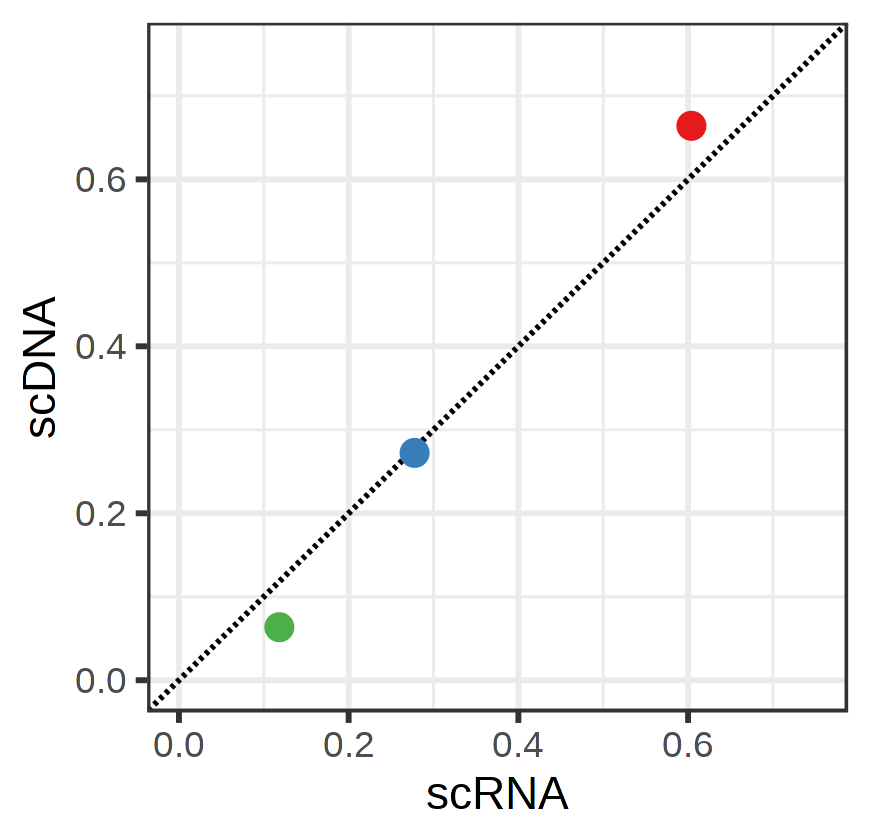

In [804]:
options(repr.plot.width = 2.9, repr.plot.height = 2.8, repr.plot.res = 300)

frac_max = 0.75

p = D %>%
    filter(clone != 1) %>%
    reshape2::dcast(clone ~ assay, value.var = 'frac', fill = 0) %>%
    ggplot(
        aes(x = scRNA, y = scDNA, color = clone)
    ) +
    geom_abline(linetype = 'dashed') +
    geom_point(size = 2.5) +
    xlim(0,frac_max) +
    ylim(0,frac_max) +
    scale_color_manual(values = c(pal[3], pal[1], pal[2])) +
    theme_bw() +
    guides(color = guide_legend(title = 'Clone'))

p + guides(color = 'none')

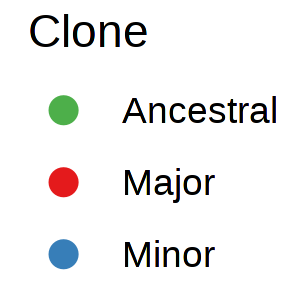

In [805]:
options(repr.plot.width = 1, repr.plot.height = 1, repr.plot.res = 300)

ggpubr::get_legend(p) %>% ggpubr::as_ggplot()

In [ ]:
options(repr.plot.width = 3, repr.plot.height = 4, repr.plot.res = 200)

ggplot(
    D,
    aes(x = assay, y = frac, fill = clone)
) +
geom_col() +
theme_classic() +
scale_x_discrete(expand = expansion(0)) +
scale_y_continuous(expand = expansion(0))

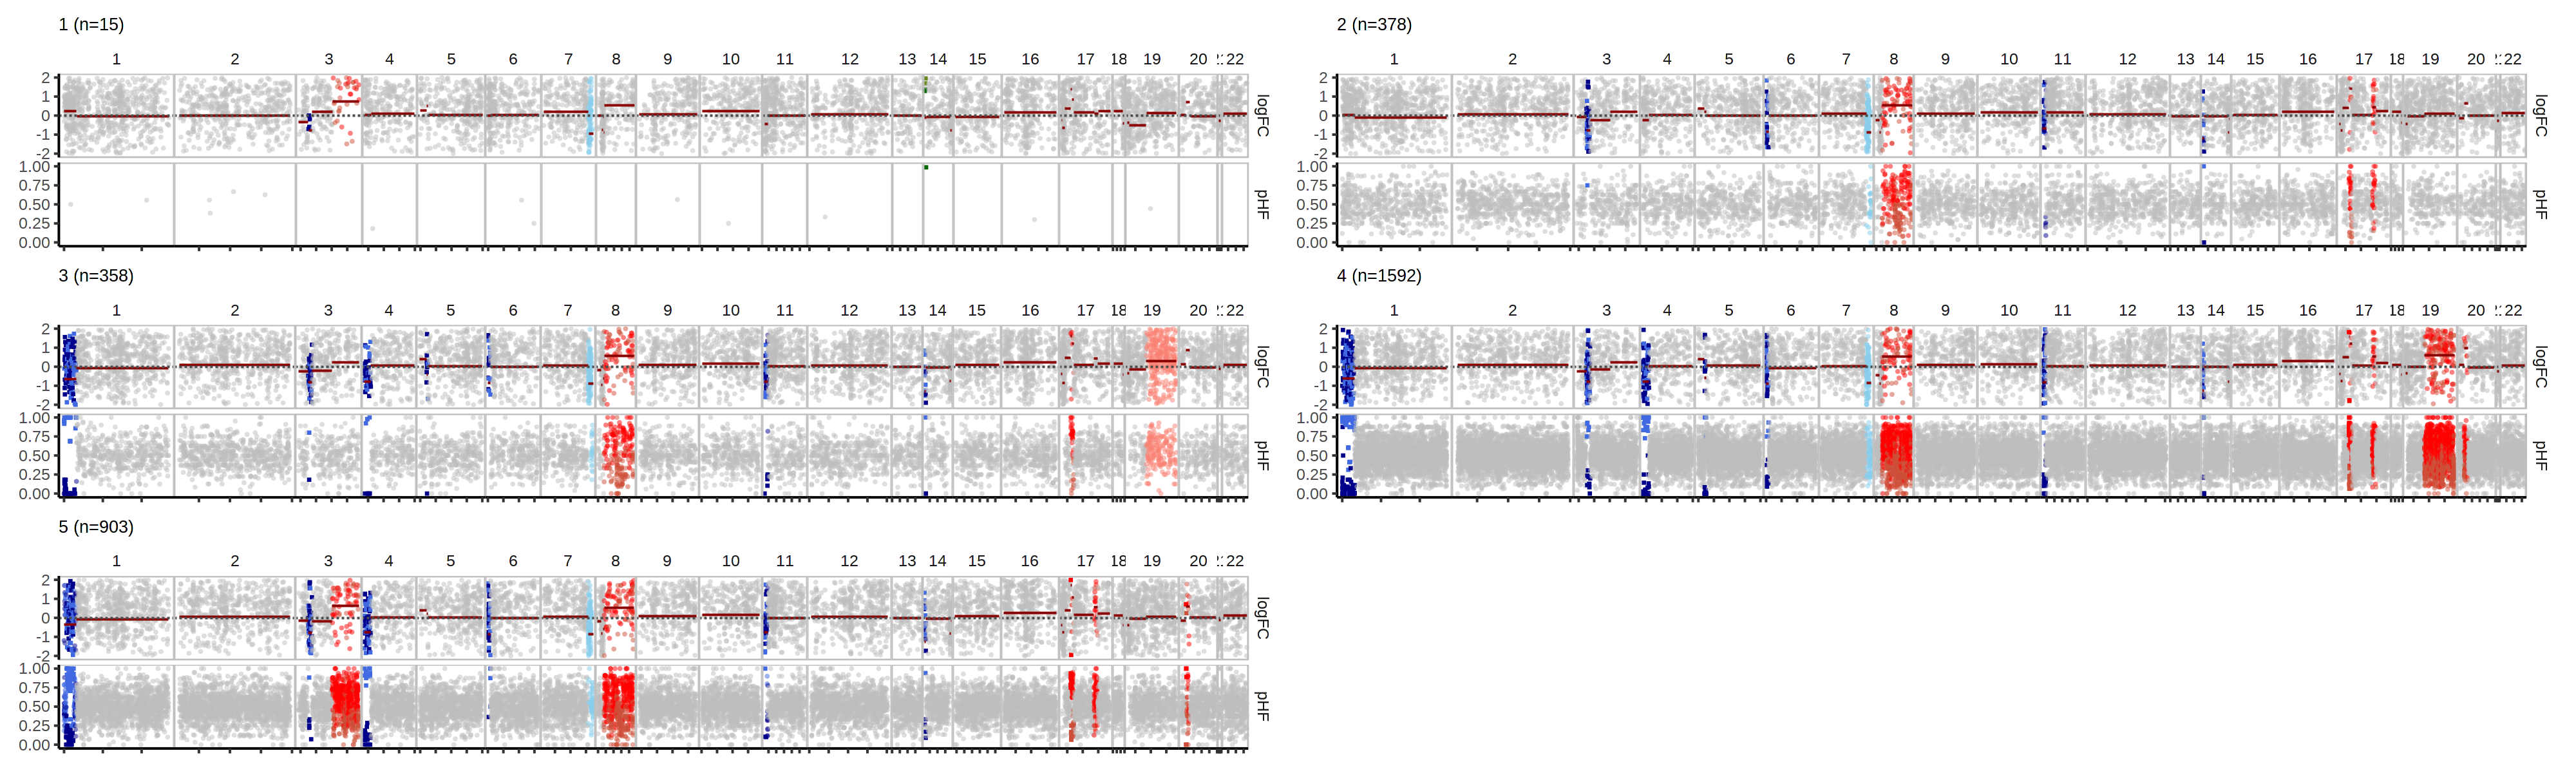

In [1681]:
options(repr.plot.width = 20, repr.plot.height = 6, repr.plot.res = 200)

bulk_clones %>% plot_bulks(ncol = 2)

# scDNA

## Cellranger

In [1443]:
rename = dplyr::rename
count = dplyr::count

In [1419]:
cnv_calls = fread('~/external/STA/scDNA/bamtofastq/outs/node_cnv_calls.bed')
n_cells = fread('~/external/STA/scDNA/bamtofastq/outs/summary.csv')$num_cells

cnv_calls = cnv_calls %>% filter(id < n_cells) %>%
    rename(CHROM = `#chrom`, seg_start = start, seg_end = end, cn = copy_number, conf = event_confidence) %>%
    mutate(p_cnv = 1-10^(conf/(-10))) %>%
    mutate(CHROM = str_remove(CHROM, 'chr')) %>%
    filter(CHROM %in% 1:22) %>%
    mutate(CHROM = factor(CHROM, 1:22))

In [1433]:
cnv_calls = cnv_calls %>% arrange(CHROM, seg_start) %>%
    mutate(bin = paste0(CHROM, ':', seg_start, '-', seg_end)) %>%
    mutate(bin_index = as.integer(factor(bin, unique(bin))))

In [1438]:
cn_mat = cnv_calls %>% reshape2::dcast(bin_index ~ id, value.var = 'cn')

In [ ]:
dist_mat = parallelDist::parDist(method = 'manhattan', rbind(P, 'outgroup' = 1), threads = 4)

treeNJ = phangorn::upgma(dist_mat) %>%
    ape::root(outgroup = 'outgroup') %>%
    ape::drop.tip('outgroup') %>%
    reorder(order = 'postorder')

## Copykit

In [ ]:
library(copykit)

In [1453]:
library(BiocParallel)

In [1457]:
register(MulticoreParam(progressbar = T, workers = 30), default = T)

In [ ]:
copykit_object <- runCountReads(
    '~/external/STA/scDNA/bam_split',
    genome = 'hg38',
    remove_Y = TRUE,
    is_paired_end = TRUE
)

In [1461]:
copykit_object <- runVst(copykit_object,
    transformation = "ft"
)

In [ ]:
seed = 17
min_bincount = 10
alpha = 1e-9
gamma = 40
method = 'multipcf'
name = 'segment_ratios'

copykit_object <- runSegmentation(copykit_object,
    seed = seed,
    name = name,
    alpha = alpha,
    gamma = gamma,
    method = method
)

In [1464]:
copykit_object <- logNorm(copykit_object,
    transform = "log"
)

In [1465]:
tumor = copykit_object

In [1466]:
# saveRDS(tumor, '~/external/STA/scDNA/copykit.rds')

In [5]:
tumor = readRDS('~/external/STA/scDNA/copykit.rds')

In [ ]:
seed = 17
min_bincount = 10
alpha = 1e-9
gamma = 40
method = 'CBS'
name = 'segment_ratios'

tumor_cbs = runSegmentation(tumor,
    seed = seed,
    name = name,
    alpha = alpha,
    gamma = gamma,
    method = method
)

In [8]:
## QC
tumor <- findAneuploidCells(tumor)
tumor <- findOutliers(tumor)
tumor <- tumor[,SummarizedExperiment::colData(tumor)$outlier == FALSE]
tumor <- tumor[,SummarizedExperiment::colData(tumor)$is_aneuploid == TRUE]

number of iterations= 8 


Copykit detected 0 that are possibly diploid cells using a resolution of: 0.051

Added information to colData(CopyKit).

Calculating correlation matrix.

Marked 36 cells as outliers.

Adding information to metadata. Access with colData(scCNA).

Done.



In [9]:
tumor <- copykit::calcInteger(tumor, method = 'fixed', ploidy_value = 1.94)

Scaling ratio values by ploidy value 1.94



In [741]:
tumor_cbs <- copykit::calcInteger(tumor_cbs, method = 'fixed', ploidy_value = 1.94)

Scaling ratio values by ploidy value 1.94



In [10]:
library(ggplot2)
library(dplyr)
library(data.table)

In [736]:
chr_ranges <- as.data.frame(SummarizedExperiment::rowRanges(tumor_cbs))

dat_ratios <- copykit::ratios(tumor_cbs) %>%
    dplyr::mutate(abspos = chr_ranges$abspos, start = chr_ranges$start, end = chr_ranges$end, chrom = chr_ranges$seqnames) %>%
    filter(chrom != 'chrX') %>%
    rename(CHROM = chrom) %>%
    mutate(CHROM = factor(str_remove(CHROM, 'chr'), 1:22)) %>%
    reshape2::melt(id.vars = c('CHROM', 'start'), variable.name = 'cell', value.name = 'ratio') %>%
    mutate(cell = paste0('NCI-N87_', str_remove(cell, '49606_NCI-N87.scrg.hd_')))

dat_segs <- copykit::segment_ratios(tumor_cbs) %>%
    dplyr::mutate(abspos = chr_ranges$abspos, start = chr_ranges$start, end = chr_ranges$end, chrom = chr_ranges$seqnames) %>%
    filter(chrom != 'chrX') %>%
    rename(CHROM = chrom) %>%
    mutate(CHROM = factor(str_remove(CHROM, 'chr'), 1:22)) %>%
    reshape2::melt(id.vars = c('CHROM', 'start'), variable.name = 'cell', value.name = 'ratio') %>%
    mutate(cell = paste0('NCI-N87_', str_remove(cell, '49606_NCI-N87.scrg.hd_')))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 10 rows containing missing values (geom_point).”


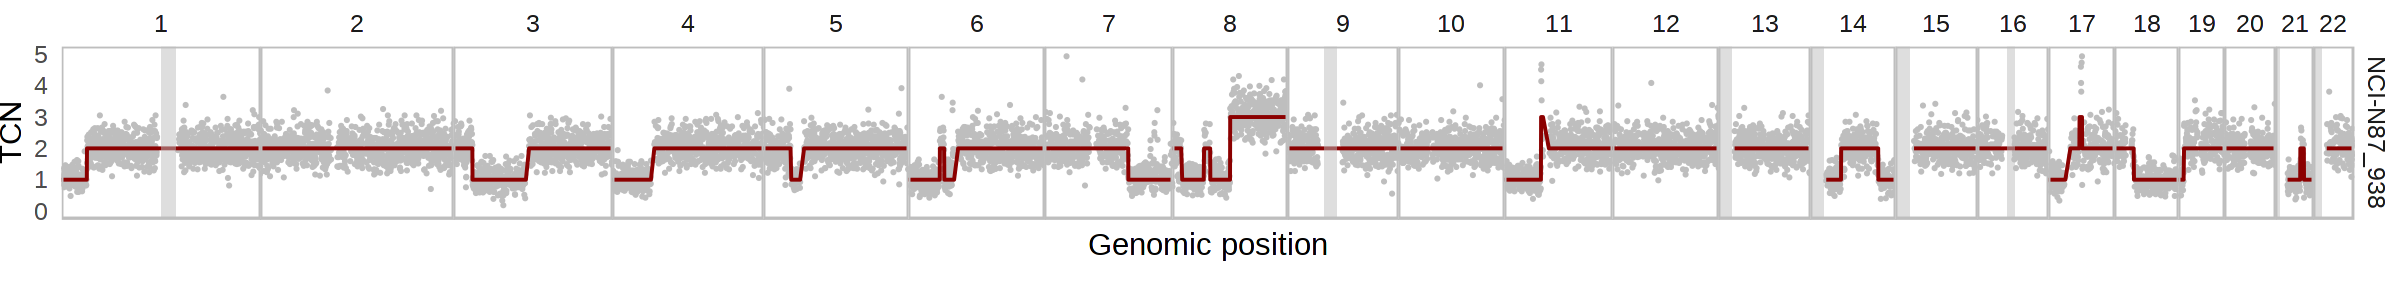

In [737]:
options(repr.plot.width = 12, repr.plot.height = 1.5, repr.plot.res = 200)

cells = paste0('NCI-N87_', c(938, 950, 965, 915))

plot_cell(dat_ratios, dat_segs, cells = cells[1], ploidy = 1.85)

In [12]:
gaps_hg38 = numbat::gaps_hg38

Warning message:
“replacing previous import ‘Matrix::expand’ by ‘ggtree::expand’ when loading ‘numbat’”


In [20]:
segs_loh = fread('~/paper_data/numbat_out/NCI-N87_new/segs_loh.tsv') %>% relevel_chrom()

In [75]:
library(stringr)
library(tidygraph)
library(ggtree)
library(patchwork)

In [746]:
chrom_labeller <- function(chr){
    chr = str_remove(chr, 'chr')
    chr[chr %in% c(19, 21, 22)] = ''
    return(chr)
}

plot_tree_heatmap = function(
    dat, tree = NULL, clone_dict = NULL, clone_line = FALSE, clone_bar = FALSE, breakpoints = NULL, tree_height = 1,
    point_size = 0.01, branch_width = 0.2, type = 'integer', pal_clone = NULL, clone_legend = TRUE) {
        
    if (type == 'integer') {
        midpoint = 2
        limits = c(1,3)
    } else {
        midpoint = 1
        limits = c(0.5, 2)
    }
    
    p_tree = ggtree(tree, size = branch_width) +
        geom_rootedge(size = branch_width) +
        theme(plot.margin = margin(0,1,0,0, unit = 'mm'))

    cell_order = p_tree$data %>% dplyr::filter(isTip == TRUE) %>% arrange(y) %>% pull(label)
    
    chrom_labeller <- function(chr){
        chr[chr %in% c(19, 21, 22)] = ''
        return(chr)
    }
    
    segs_exclude = gaps_hg38 %>% filter(end - start > 1e6) %>%
        dplyr::rename(seg_start = start, seg_end = end)
    
    dat = dat %>% mutate(cell = factor(cell, cell_order)) %>%
        arrange(cell) %>%
        mutate(cell_index = as.integer(factor(cell, cell_order))) %>%
        mutate(CHROM = str_remove(CHROM, 'chr')) %>%
        mutate(CHROM = factor(CHROM, 1:22))
    
    if (clone_line) {
        dat = dat %>% mutate(clone = clone_dict[as.character(cell)])
    } else {
        dat = dat %>% mutate(clone = 1)
    }
    
    p_heatmap = dat %>%
        ggplot(
            aes(x = seg_start, xend = seg_end, y = cell, yend = cell, color = cn)
        ) +
#         geom_rect() +
        geom_segment() +
        geom_rect(
            inherit.aes = F,
            data = segs_exclude, 
            aes(xmin = seg_start,
                xmax = seg_end,
                ymin = -Inf,
                ymax = Inf
            ),
            fill = 'gray95'
        ) +
        facet_grid(clone~CHROM, scale = 'free', space = 'free', labeller = labeller(CHROM = chrom_labeller)) +
        theme_classic() +
        theme(
            panel.spacing = unit(0, 'mm'),
            panel.border = element_rect(size = 0.5, color = 'gray', fill = NA),
            strip.background = element_blank(),
            strip.text.y = element_blank(),
            axis.text = element_blank(),
#             axis.text.y = element_text(size = 5),
            axis.title.y = element_blank(),
            axis.title.x = element_text(size = 10),
            axis.ticks = element_blank(),
            plot.margin = margin(0,0,0,0, unit = 'mm'),
            axis.line = element_blank()
        ) +
        scale_x_discrete(expand = expansion(0)) +
        scale_y_discrete(expand = expansion(0)) +
        scale_color_gradient2(
            low = 'darkblue', mid = 'white', high = 'darkred', breaks = c(1,2,3),
            midpoint = midpoint, limits = limits, oob = scales::oob_squish,
            labels = c('del', 'neu', 'amp')
        ) +
        guides(color = guide_legend(title = 'CNV state'))
    
    if (clone_line) {
        p_heatmap = p_heatmap + 
            theme(
                strip.background.y = element_rect(size = 0.2, color = 'darkslategray', fill = 'whitesmoke'),
                strip.text.y = element_text()
            )
    }
    
    if (clone_bar) {
        p_clone = data.frame(
                cell = names(clone_dict),
                annot = factor(unname(clone_dict))
            ) %>%
            mutate(cell = factor(cell, cell_order)) %>%
            filter(!is.na(cell)) %>%
            annot_bar(transpose = TRUE, legend_title = 'Clusters', pal_annot = pal_clone, legend = clone_legend)
    }

    if (clone_bar) {
        (p_tree | p_clone | p_heatmap) + plot_layout(widths = c(tree_height, 0.25, 15), guides = 'collect')
    } else {
        (p_tree | p_heatmap) + plot_layout(widths = c(tree_height,10), guides = 'collect')
    }

}

In [742]:
dat_cn = tumor_cbs@assays@data[['integer']] %>% 
    dplyr::mutate(POS = chr_ranges$abspos, start = chr_ranges$start, end = chr_ranges$end, CHROM = chr_ranges$seqnames)

dist_mat = dat_cn %>% 
    select(-any_of(c('POS', 'start', 'end', 'CHROM'))) %>%
    as.matrix %>% t %>%
    rbind('outgroup' = 2) %>%
    parallelDist::parDist(., method = 'manhattan', threads = 8)

hc = hclust(dist_mat, method = 'ward.D2')

treeUPGMA = hc %>%
    as.phylo %>%
    ape::root('outgroup') %>% 
    ape::drop.tip('outgroup')

In [743]:
seg_cn = dat_cn %>%
    filter(CHROM != 'chrX') %>%
    reshape2::melt(id.var = c('CHROM', 'POS', 'start', 'end'), variable.name = 'cell', value.name = 'cn') %>%
    mutate(CHROM = str_remove(CHROM, 'chr')) %>%
    mutate(CHROM = factor(CHROM, unique(CHROM))) %>%
    group_by(cell, CHROM) %>%
    arrange(POS) %>%
    mutate(boundary = c(0, cn[2:length(cn)] != cn[1:(length(cn)-1)])) %>%
    group_by(cell, CHROM) %>%
    mutate(seg = paste0(CHROM, letters_all[cumsum(boundary)+1])) %>%
    group_by(cell, CHROM, seg, cn) %>%
    summarise(
        seg_start = min(start),
        seg_end = max(end),
        .groups = 'drop'
    ) %>%
    ungroup()

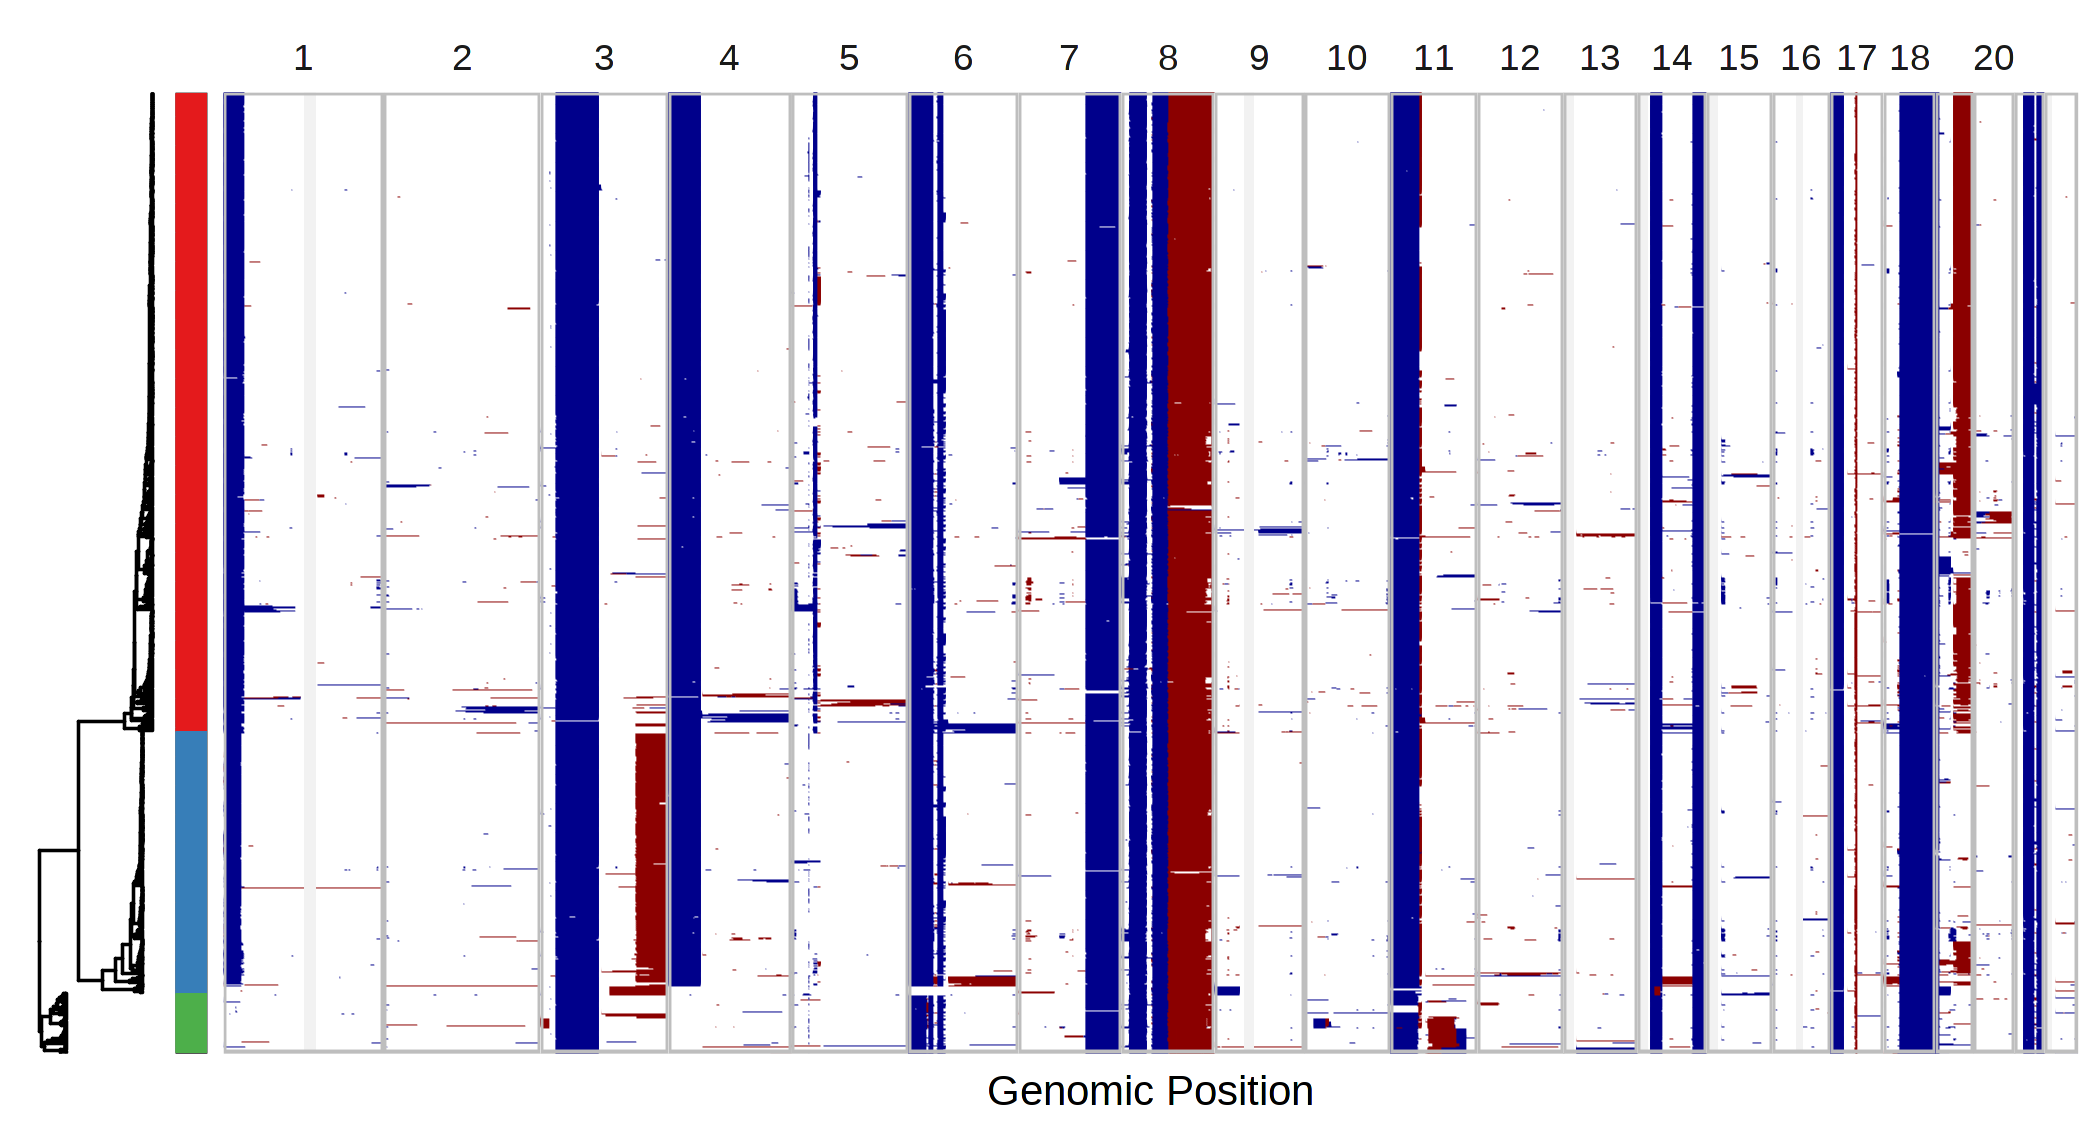

In [816]:
options(repr.plot.width = 7, repr.plot.height = 3.8, repr.plot.res = 300)
R.utils::sourceDirectory('~/Numbat/R')
tip_length = 1

p = plot_tree_heatmap(
    seg_cn, 
    treeUPGMA,
    clone_dict = cutree(hc, k = 3),
    clone_line = FALSE,
    type = 'integer',
    tree_height = 1,
    branch_width = 0.3,
    clone_bar = TRUE,
    clone_legend = FALSE,
    pal_clone = c('1' = pal[1], '2' = pal[2], '3' = pal[3])
) +
xlab('Genomic Position')

p + guides(color = 'none')

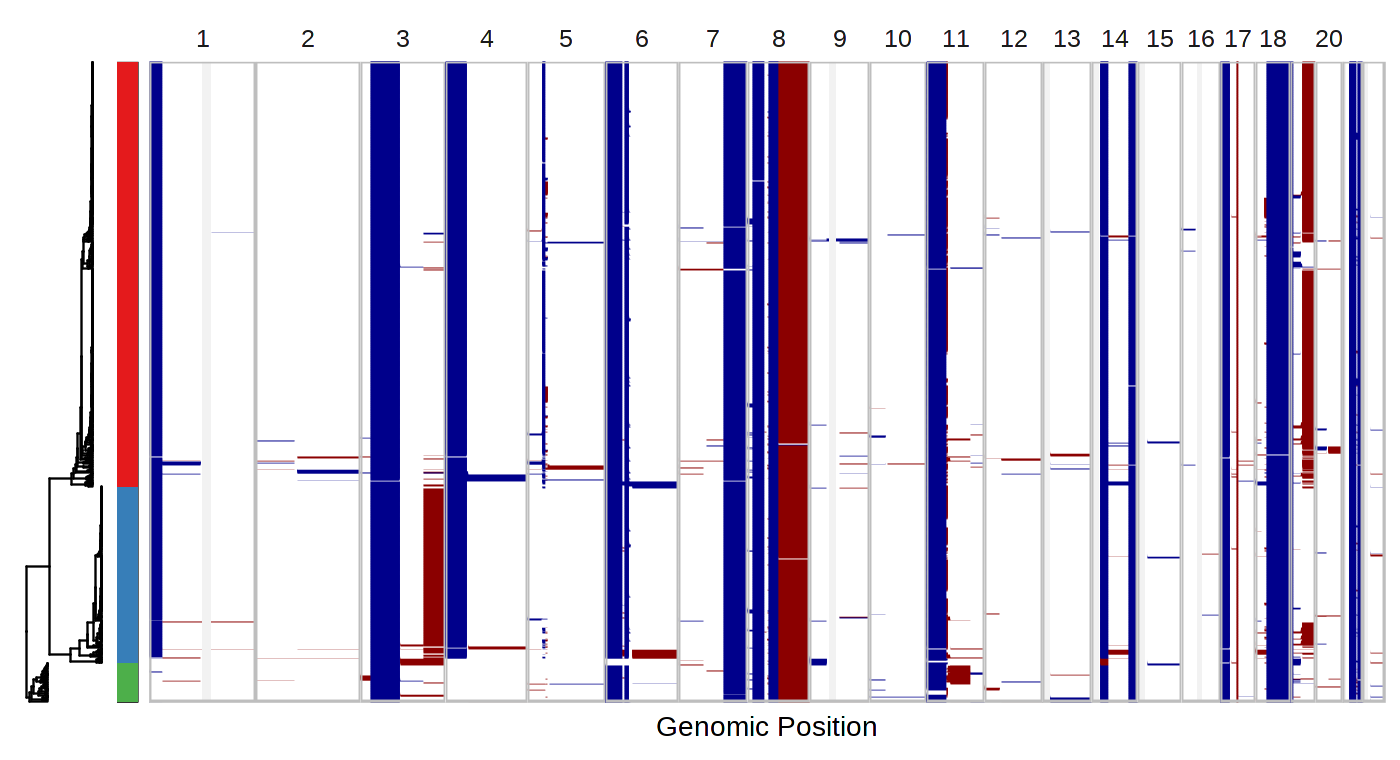

In [1849]:
options(repr.plot.width = 7, repr.plot.height = 3.8, repr.plot.res = 200)
R.utils::sourceDirectory('~/Numbat/R')
tip_length = 1

plot_tree_heatmap(
    seg_cn, 
    treeUPGMA,
    clone_dict = cutree(hc, k = 3),
    clone_line = FALSE,
    type = 'integer',
    tree_height = 1,
    branch_width = 0.3,
    clone_bar = TRUE,
    clone_legend = FALSE,
    pal_clone = c('1' = pal[1], '2' = pal[2], '3' = pal[3])
) +
guides(color = 'none') +
xlab('Genomic Position')

In [748]:
df_cn = dat_cn %>%
    filter(CHROM != 'chrX') %>%
    reshape2::melt(id.var = c('CHROM', 'POS', 'start', 'end'), variable.name = 'cell', value.name = 'cn') %>%
    mutate(CHROM = str_remove(CHROM, 'chr')) %>%
    mutate(CHROM = factor(CHROM, unique(CHROM))) 

clone_cn = df_cn %>%
    mutate(clone = clusters[as.character(cell)]) %>%
    group_by(CHROM, start, end, clone) %>%
    summarise(
        cn = mean(cn),
        .groups = 'drop'
    )

dna_clone_segs = clone_cn %>% 
    mutate(cn = round(cn)) %>%
    group_by(clone) %>%
    arrange(CHROM, start) %>%
    mutate(boundary = c(0, cn[2:length(cn)] != cn[1:(length(cn)-1)])) %>%
    group_by(clone, CHROM) %>%
    mutate(seg = paste0(CHROM, letters_all[cumsum(boundary)+1])) %>%
    group_by(clone, CHROM, seg, cn) %>%
    summarise(
        seg_start = min(start),
        seg_end = max(end),
        .groups = 'drop'
    ) %>%
    ungroup() %>%
    mutate(cnv_state = case_when(
        cn == 2 ~ 'neu',
        cn > 2 ~ 'amp',
        cn < 2 ~ 'del'
    )) 

In [512]:
dna_clone_segs %>% fwrite('~/paper_data/cnv_benchmark/NCI-N87_segs_dna.tsv', sep = '\t')

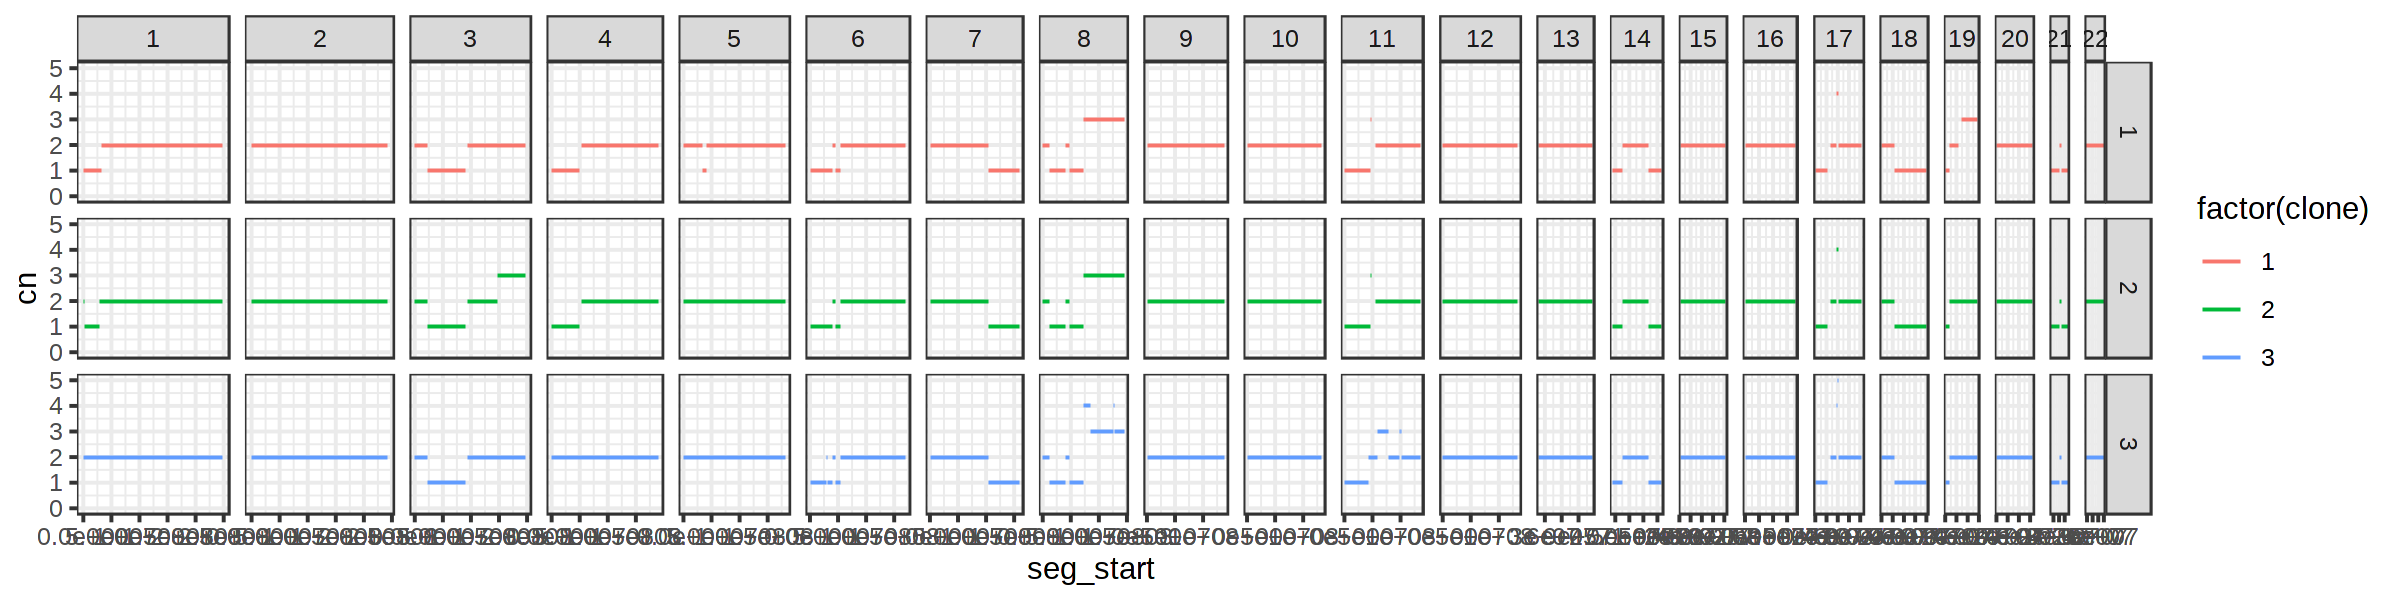

In [749]:
options(repr.plot.width = 12, repr.plot.height = 3, repr.plot.res = 200)

dna_clone_segs %>%
ggplot(
    aes(x = seg_start, xend = seg_end, y = cn, yend = cn, color = factor(clone))
) +
geom_segment() +
facet_grid(clone~CHROM, space = 'free_x', scale = 'free_x') +
ylim(0,5) +
theme_bw()

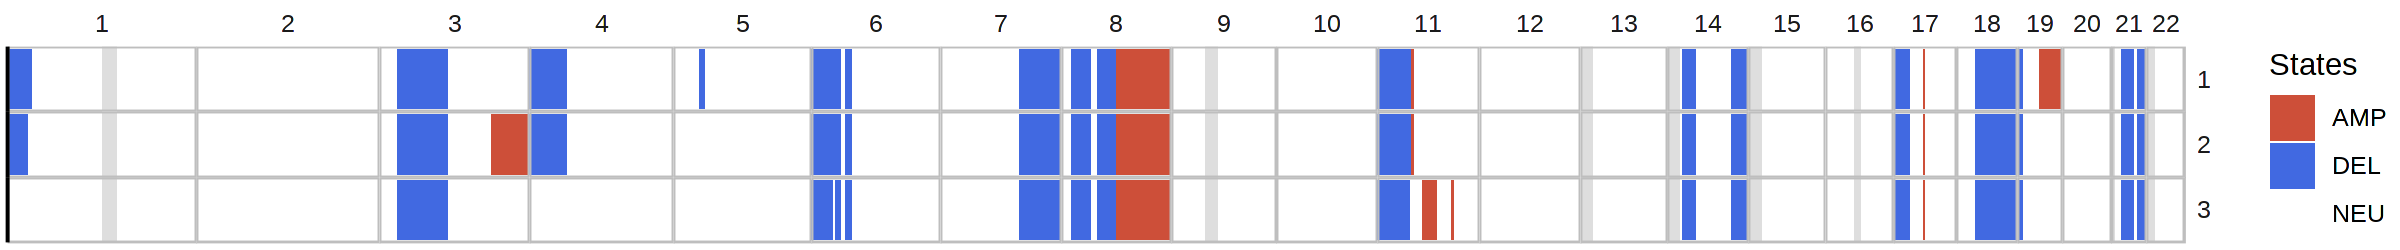

In [750]:
options(repr.plot.width = 12, repr.plot.height = 1.25, repr.plot.res = 200)

dna_clone_segs %>% cnv_heatmap(var = 'clone')

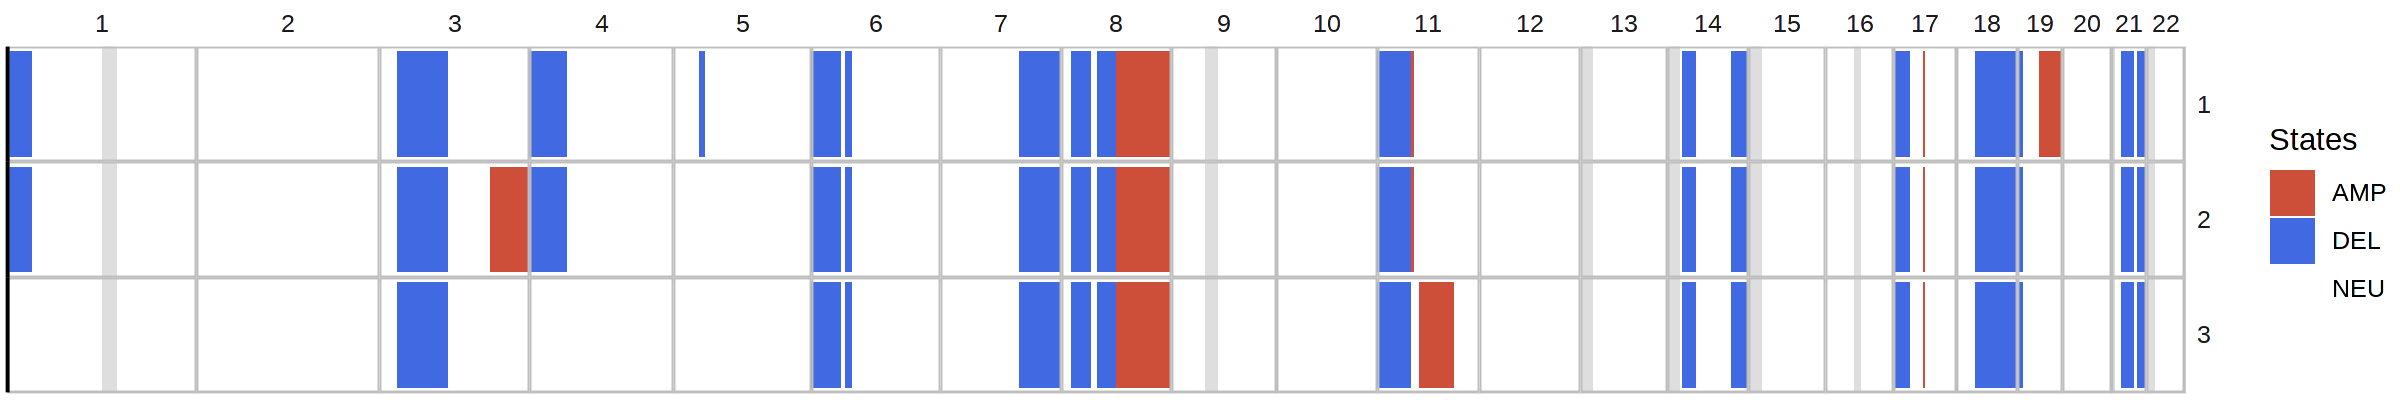

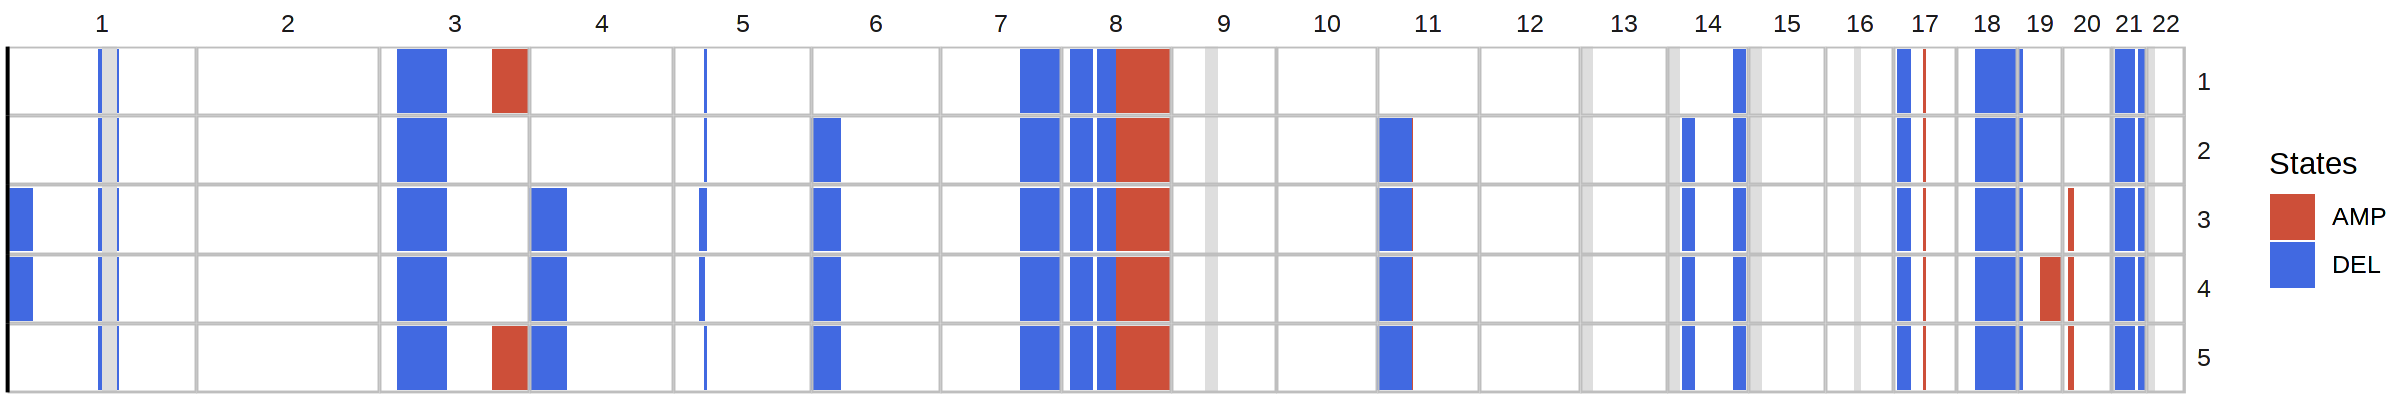

In [451]:
options(repr.plot.width = 12, repr.plot.height = 2, repr.plot.res = 200)

clone_segs %>% cnv_heatmap(var = 'clone')
clone_profiles %>% filter(p_cnv > 0.5) %>% 
    mutate(p_cnv = 1) %>%
    cnv_heatmap(var = 'clone')

# Stability

In [576]:
get_clone_scores = function(rna_clone_segs, dna_clone_segs) {
    
    # compare one set of clone profiles with DNA
    scores = lapply(
            1:3,
            function(clone_dna) {
                lapply(
                    unique(rna_clone_segs$clone),
                    function(clone_rna) {

                        segs_dna = dna_clone_segs %>% filter(clone == clone_dna) %>% filter(cnv_state != 'neu')
                        segs_rna = rna_clone_segs %>% filter(clone == clone_rna) %>% filter(p_cnv > 0.5)

                        jac = compare_segs(segs_dna, segs_rna)

                        res = evaluate_calls(segs_dna, segs_rna) %>% t %>% 
                            as.data.frame() %>%
                            mutate(clone_dna = clone_dna, clone_rna = clone_rna, jac = jac) %>%
                            mutate(F1 = 2 * (precision * recall)/(precision + recall)) %>%
                            left_join(
                                rna_clone_segs %>% distinct(clone, size),
                                by = c('clone_rna' = 'clone')
                            )

                    }
                ) %>% bind_rows()
            }
        ) %>% bind_rows()
    
    return(scores)
    
}

In [542]:
scores = list()

In [751]:
scores[['iter']] = mclapply(
        as.character(1:5),
        mc.cores = 10,
        function(i) {
            out_dir = glue('~/paper_data/numbat_out/NCI-N87_test_iter')
            joint_post = fread(glue('{out_dir}/joint_post_{i}.tsv'))
            clone_post = fread(glue('{out_dir}/clone_post_{i}.tsv'))
            clone_profiles = get_clone_profile(joint_post, clone_post) 
            scores = get_clone_scores(clone_profiles, dna_clone_segs) %>%
                mutate(value = i, param = 'iter')
            return(scores)
        }
    ) %>%
    bind_rows()

In [887]:
param_values = list(
    'tau' = as.character(seq(0.1, 0.5, 0.1)),
    'k' = as.character(1:5),
    'overlap' = as.character(c(0.15, 0.3, 0.45, 0.6, 0.75)),
    'random' = as.character(1:5)
)

for (param in c('tau', 'k', 'overlap', 'random')) {
    
    message(param)
    
    scores[[param]] = mclapply(
            param_values[[param]],
            mc.cores = 10,
            function(value) {
                out_dir = glue('~/paper_data/numbat_out/NCI-N87_test_{param}_{value}')
                joint_post = fread(glue('{out_dir}/joint_post_2.tsv'))
                clone_post = fread(glue('{out_dir}/clone_post_2.tsv'))
                clone_profiles = get_clone_profile(joint_post, clone_post) 
                scores = get_clone_scores(clone_profiles, dna_clone_segs) %>%
                    mutate(value = UQ(value), param = param)
                return(scores)
            }
        ) %>%
        bind_rows()
    
}

random



In [656]:
param = 'random'
value = 1
out_dir = glue('~/paper_data/numbat_out/NCI-N87_test_{param}_{value}')
joint_post = fread(glue('{out_dir}/joint_post_2.tsv'))
clone_post = fread(glue('{out_dir}/clone_post_2.tsv'))
rna_clone_segs = get_clone_profile(joint_post, clone_post)

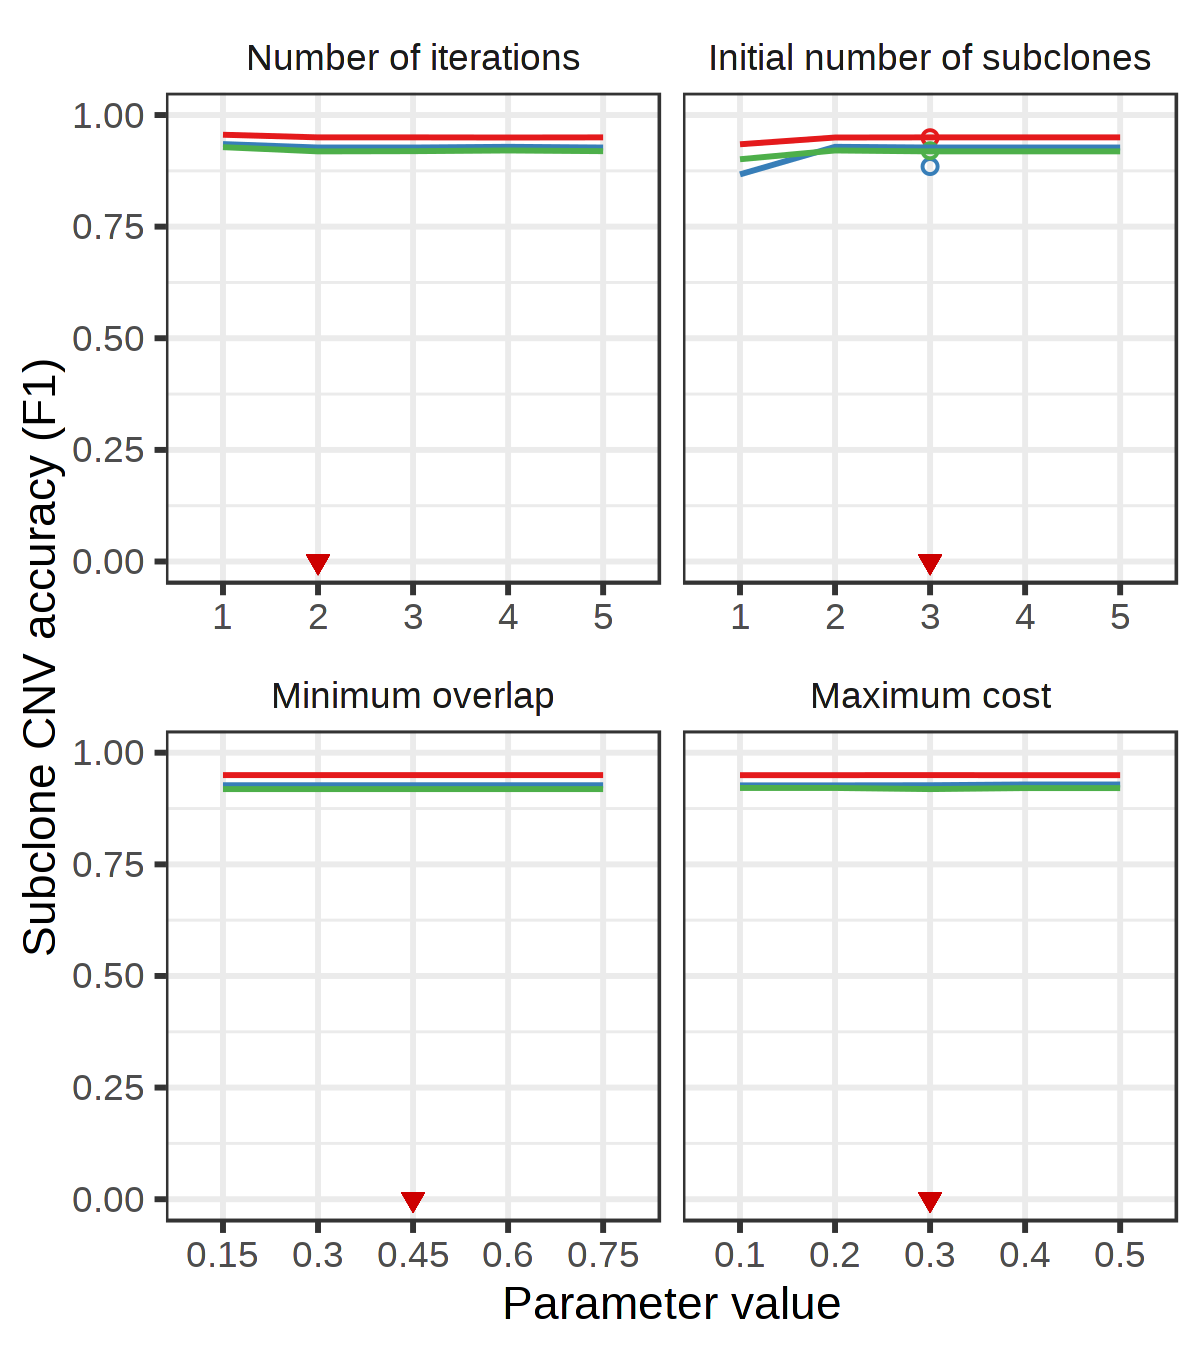

In [900]:
options(repr.plot.width = 4, repr.plot.height = 4.5, repr.plot.res = 300)

param_titles = c('iter' = 'Number of iterations', 'k' = 'Initial number of subclones', 
                 'overlap' = 'Minimum overlap', 'tau' = 'Maximum cost', 'random' = 'Random tree seed')

random_scores = bind_rows(scores) %>% 
    filter(param == 'random') %>%
    filter(value == 1) %>%
    group_by(clone_dna, param, value) %>%
    summarise(
        rna_match = which.max(jac),
        precision = precision[rna_match],
        F1 = F1[rna_match],
        jac = jac[rna_match],
        recall = recall[rna_match],
        .groups = 'drop'
    )

defaults = c('k' = '3', 'tau' = '0.3', 'overlap' = '0.45', 'iter' = '2')

bind_rows(scores) %>%
filter(param != 'random') %>%
mutate(size = unlist(as.list(table(clusters)))[clone_dna]) %>%
group_by(clone_dna, param, value) %>%
summarise(
    rna_match = which.max(jac),
    precision = precision[rna_match],
    F1 = F1[rna_match],
    jac = jac[rna_match],
    recall = recall[rna_match],
    size = unique(size),
    .groups = 'drop'
) %>%
mutate(clone_dna = factor(clone_dna)) %>%
mutate(default = defaults[param]) %>%
arrange(param) %>%
mutate(param = param_titles[param]) %>%
tidyr::pivot_longer(c('precision', 'recall', 'jac', 'F1'), names_to = 'metric', values_to = 'score') %>%
mutate(param = factor(param, unname(param_titles))) %>%
filter(metric == 'F1') %>%
ggplot(
    aes(x = value, y = score, color = clone_dna, group = clone_dna)
) +
geom_point(
    data = random_scores %>% 
        mutate(
            param = factor(param_titles['k'], unname(param_titles)), score = F1, clone_dna = factor(clone_dna), value = '3'
        ),
    pch = 21,
    size = 1.25
) +
geom_line() +
ylim(0,1) +
scale_color_manual(
    values = c('1' = pal[1], '2' = pal[2], '3' = pal[3])
) +
geom_point(aes(x = default), y = 0, pch = 25, color = 'red3', fill = 'red3', stroke = 0, size = 2) +
theme_bw() +
guides(color = 'none') +
theme(strip.background = element_blank()) +
facet_wrap(~param, scales = 'free_x') +
ylab('Subclone CNV accuracy (F1)') +
xlab('Parameter value')

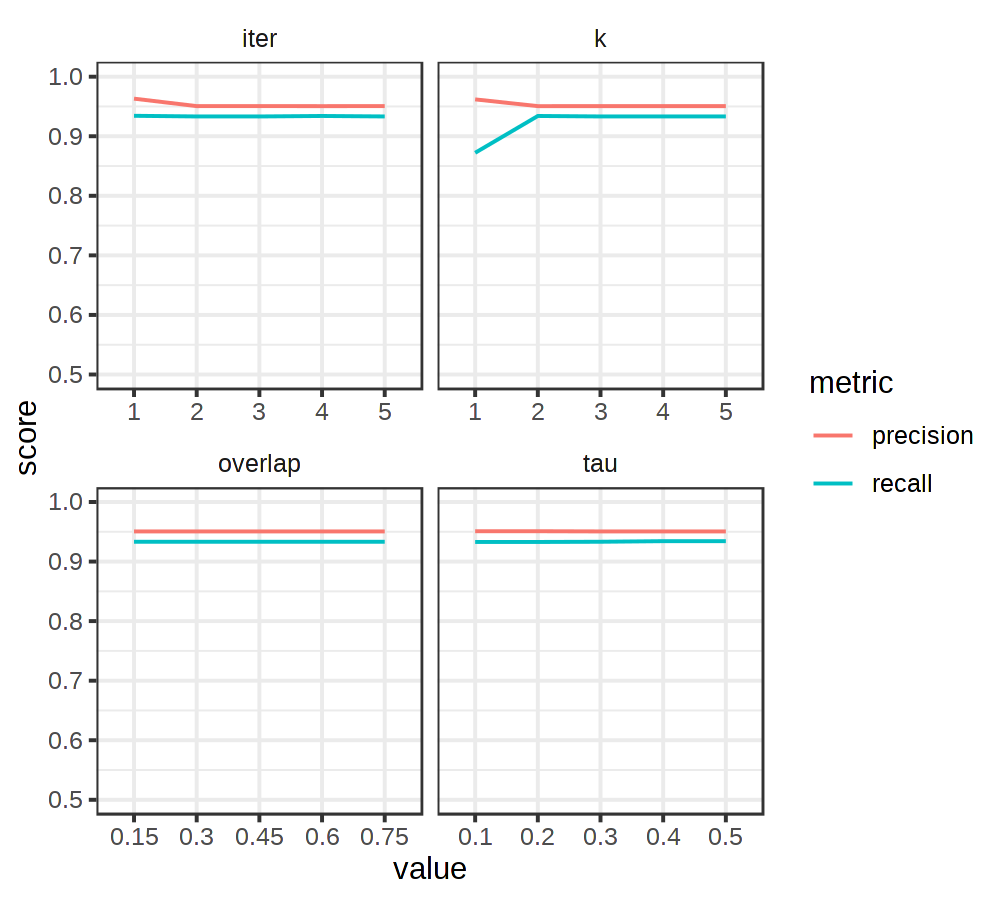

In [754]:
options(repr.plot.width = 5, repr.plot.height = 4.5, repr.plot.res = 200)

bind_rows(scores) %>%
filter(param != 'random') %>%
mutate(size = unlist(as.list(table(clusters)))[clone_dna]) %>%
group_by(clone_dna, param, value) %>%
summarise(
    rna_match = which.max(jac),
    precision = precision[rna_match],
    recall = recall[rna_match],
    size = unique(size),
    .groups = 'drop'
) %>%
group_by(param, value) %>%
mutate(frac = size/sum(size)) %>%
summarise(
    precision = sum(frac * precision),
    recall = sum(frac * recall),
    .groups = 'drop'
) %>%
tidyr::pivot_longer(c('precision', 'recall'), names_to = 'metric', values_to = 'score') %>%
ggplot(
    aes(x = value, y = score, color = metric, group = metric)
) +
geom_line() +
ylim(0.5,1) +
# geom_point() +
theme_bw() +
theme(strip.background = element_blank()) +
facet_wrap(~param, scales = 'free_x')

In [615]:
scores %>%
bind_rows() %>%
# mutate(size = unlist(as.list(table(clusters)))[clone_dna]) %>%
group_by(clone_rna, param, value) %>%
summarise(
    dna_match = which.max(jac),
    precision = precision[dna_match],
    recall = recall[dna_match],
    size = unique(size),
    .groups = 'drop'
) %>%
group_by(param, value) %>%
mutate(frac = size/sum(size)) %>%
summarise(
    precision = sum(frac * precision),
    recall = sum(frac * recall),
    .groups = 'drop'
)

param   value precision recall   
1  k       1     0.9632174 0.8618725
2  k       2     0.9517885 0.9181607
3  k       3     0.9511573 0.9175356
4  k       4     0.9511573 0.9175356
5  k       5     0.9511573 0.9175356
6  overlap 0.15  0.9511573 0.9175356
7  overlap 0.3   0.9511573 0.9175356
8  overlap 0.45  0.9511573 0.9175356
9  overlap 0.6   0.9511573 0.9175356
10 overlap 0.75  0.9511573 0.9175356
11 random  1     0.9587496 0.9131872
12 random  2     0.9586525 0.9143894
13 random  3     0.9602856 0.9133314
14 random  4     0.9581562 0.9045522
15 random  5     0.9594143 0.9064751
16 tau     0.1   0.9513213 0.9176403
17 tau     0.2   0.9513213 0.9176403
18 tau     0.3   0.9511573 0.9175356
19 tau     0.4   0.9522608 0.9206525
20 tau     0.5   0.9522608 0.9206525
21 NA      NA    0.9645882 0.9204428

In [683]:
R.utils::sourceDirectory('~/Numbat/R')

samples_MM = c('58408_SMM', '58408_Primary', 
            '47491_SMM', '47491_Primary',
            '27522_Primary', '27522_Relapse_2',
            '27522_Remission', '27522_Relapse_1',
            '37692_Primary', '59114_Relapse_1')

samples_MDA = c(paste0('ATC', 1:5), paste0('TNBC', 1:5), c('DCIS1'))

segs_loh_all = mclapply(
    mc.cores = 22,
    c(samples_MM, samples_MDA),
    function(sample) {
        
        count_mat = readRDS(glue('~/paper_data/processed/{sample}_counts.rds'))
        df = fread(glue('~/paper_data/processed/{sample}_allele_counts.tsv.gz'))

        bulk = get_bulk(
            count_mat,
            ref_hca,
            df,
            gtf_hg38,
            genetic_map_hg38
        )
        
        segs_loh = bulk %>% detect_loh(t = 1e-4) %>% mutate(sample = UQ(sample))
        
        return(segs_loh)
    }
) %>%
bind_rows()

In [686]:
segs_loh_all %>% mutate(length = (seg_end - seg_start)/1e6) %>% arrange(CHROM)

CHROM seg seg_start seg_end   snp_rate  loh  sample          length   
1  1     1b  144887191 146151908  8.201571 TRUE 58408_SMM        1.264717
2  1     1b  144887191 146151908  8.323606 TRUE 58408_Primary    1.264717
3  1     1b  144887191 148102046  4.169346 TRUE 47491_SMM        3.214855
4  1     1b  144887191 146938545  1.435163 TRUE 27522_Primary    2.051354
5  1     1b  144887191 146151908  8.201571 TRUE 27522_Remission  1.264717
6  1     1b   22451851  23084023 56.164278 TRUE 27522_Relapse_1  0.632172
7  1     1b  144887191 146151908  8.201571 TRUE 37692_Primary    1.264717
8  1     1b  144887191 148102046  3.604609 TRUE 59114_Relapse_1  3.214855
9  1     1b  120912238 146064699  7.920150 TRUE ATC2            25.152461
10 1     1b  114567560 151198552  6.344162 TRUE ATC4            36.630992
11 1     1b   21217250  43526037 21.026325 TRUE TNBC5           22.308787
12 1     1d   67407810  94974405 19.900411 TRUE TNBC5           27.566595
13 1     1f  113390515 146064699 11.847960 TRUE TNBC5           32.674184
14 3     3b   50227068  53088485  9.811001 TRUE ATC5             2.861417
15 3     3b   48856926  52245759  8.556842 TRUE DCIS1            3.388833
16 9     9b  128149453 129094794  3.290857 TRUE TNBC4            0.945341
17 9     9d  136658856 137174784  9.169369 TRUE TNBC4            0.515928
18 12    12b 107685732 112418947  7.154398 TRUE TNBC3            4.733215
19 12    12b  53500921  56224342 15.013435 TRUE TNBC5            2.723421
20 13    13b  32400723 109752695 13.269010 TRUE ATC4            77.351972
21 16    16b  66508003  68298034  9.532600 TRUE 47491_SMM        1.790031
22 16    16b  66934471  68020919 17.216147 TRUE ATC2             1.086448
23 16    16b  58707131  68264526  3.585678 TRUE TNBC5            9.557395
24 17    17b  39637080  42833397 19.063670 TRUE ATC5             3.196317
25 17    17b  21126928  28724348  1.964304 TRUE TNBC5            7.597420
26 17    17d  39688084  44319625 18.067288 TRUE TNBC5            4.631541
27 21    21b   5116341   7744921  8.513692 TRUE 58408_Primary    2.628580

In [687]:
segs_loh

CHROM seg seg_start seg_end   snp_rate  loh 
1  1     1b  120150898 146938545  8.150442 TRUE
2  3     3b   23203102  88059255 11.635877 TRUE
3  6     6a     292057  39188971 11.608710 TRUE
4  7     7b  105532081 156669012 10.732211 TRUE
5  8     8b   12721906  41578200 11.753209 TRUE
6  8     8d   47260938  70573218  5.160366 TRUE
7  11    11a    202924  36483771 10.914731 TRUE
8  14    14b  20343614  31025106 13.142835 TRUE
9  14    14d  87933014 103334237 11.917624 TRUE
10 17    17b   4269217  21284711 16.085867 TRUE
11 18    18b  24162052  80109262  8.486883 TRUE
12 19    19a    305575   6739680 25.208476 TRUE
13 21    21a   5022554  31118418  9.148969 TRUE
14 21    21c  36070024  46235133 13.641779 TRUE